export HDF5_USE_FILE_LOCKING=FALSE

In [1]:
import sys
from brahma_analysis import *
from scipy.interpolate import interp1d
sys.path.append('/home/yja6qa/arepo_package/')

import arepo_package
import scipy.interpolate
import h5py
import os
import numpy as np
import plotting
from sklearn.linear_model import LinearRegression
from scipy.interpolate import interp1d
import time
from scipy.signal import savgol_filter
from scipy.optimize import brentq
from scipy.optimize import curve_fit

%matplotlib inline
radiative_efficiency=0.2

# Removing gradient from stellar potentials

In [2]:
TNGpath='/standard/torrey-group/IllustrisTNG/Runs/L75n1820TNG'
basePath = TNGpath
snap_num=99 # z=0
hdr  = il.groupcat.loadHeader(TNGpath, snap_num)
h = hdr['HubbleParam'] ## load in h from the header
box_size = hdr["BoxSize"]
redshift = hdr['Redshift']

In [3]:
subhalo_id = 50 # Desired_subhalos[i] # 31424, 76150
# print("Subhalo {}".format(Desired_subhalos[i]))
kpc2km = 3.0857e16
Subhaloprops = il.groupcat.loadSubhalos(basePath,snap_num,fields=['SubhaloPos','SubhaloVel','SubhaloHalfmassRad'])
HMR = Subhaloprops['SubhaloHalfmassRad'][subhalo_id]

fields = ['Masses','Coordinates','Velocities','Potential']
Star_Props = il.snapshot.loadSubhalo(basePath, snap_num, id=subhalo_id, partType=4, fields=fields)

Coordinates,Velocities,Potentials = Center_subhalo(Star_Props,Subhaloprops,box_size,redshift,h,subhalo_id=subhalo_id)

In [29]:
rstars = np.sqrt(Coordinates[:,0]**2 + Coordinates[:,1]**2)
r_out_HMR_mask = rstars > np.percentile(rstars, 95) # stars outside 95th percentile of stellar radius
r_out_HMR = rstars[r_out_HMR_mask]

def model(xy, a, b, c):
    x, y = xy
    return a * x + b * y + c
    
x = Coordinates[:,0][r_out_HMR_mask]
y = Coordinates[:,1][r_out_HMR_mask]
Potentials_masked = Potentials[r_out_HMR_mask]

params, covariance = curve_fit(model, (x, y), Potentials_masked)
print("Fitted parameters:", params)

Fitted parameters: [-1.20721655e-15  1.77312492e-14 -1.50607357e+06]


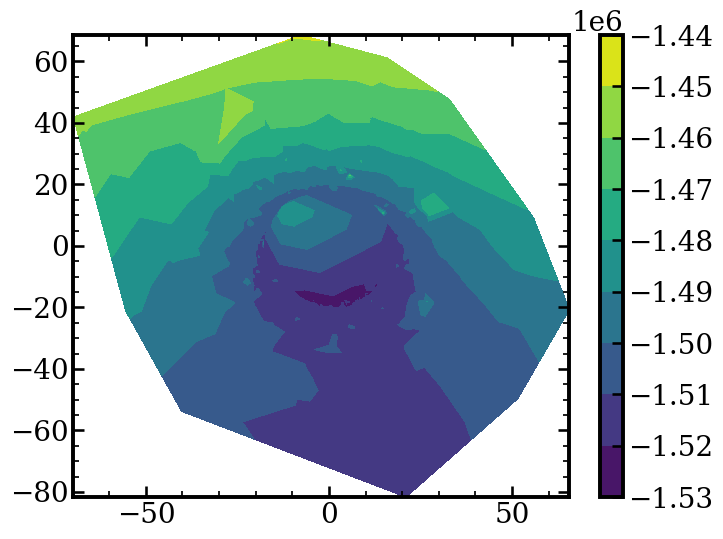

In [30]:
xcirc = np.linspace(-2*HMR,2*HMR,1000)
ycirca = np.sqrt((2*HMR)**2 - xcirc**2)
ycircb = -np.sqrt((2*HMR)**2 - xcirc**2)

plt.figure(figsize=(8, 6))
contour = plt.tricontourf(x/kpc2km, y/kpc2km, Potentials_masked, cmap='viridis')
# plt.plot(xcirc,ycirca,color='orange')
# plt.plot(xcirc,ycircb,color='orange')
plt.colorbar(contour)


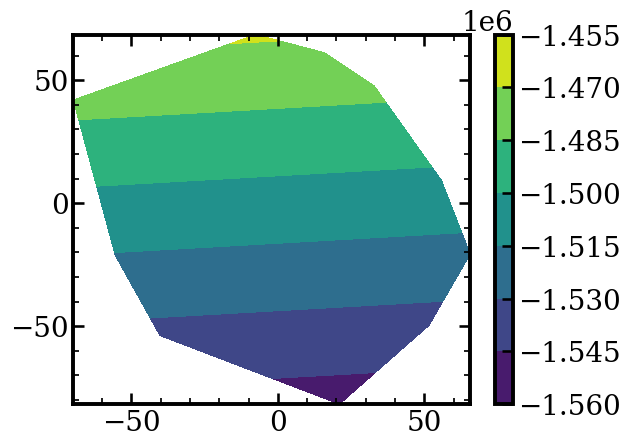

In [31]:
fitted_Z = model((Coordinates[:,0], Coordinates[:,1]), *params)
contour=plt.tricontourf(Coordinates[:,0]/kpc2km, Coordinates[:,1]/kpc2km, fitted_Z, cmap='viridis')
plt.colorbar(contour)


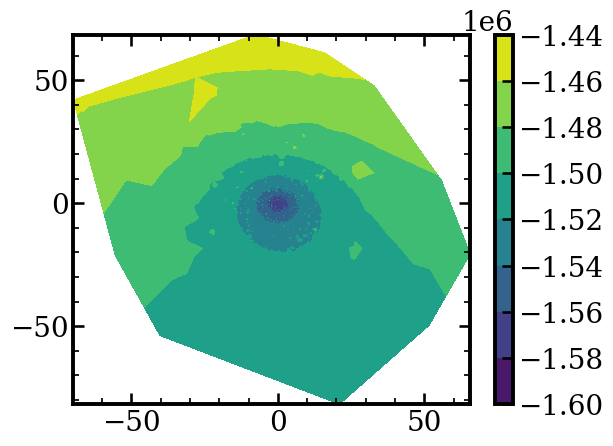

In [32]:
contour=plt.tricontourf(Coordinates[:,0]/kpc2km, Coordinates[:,1]/kpc2km, Potentials, cmap='viridis')
plt.colorbar(contour)

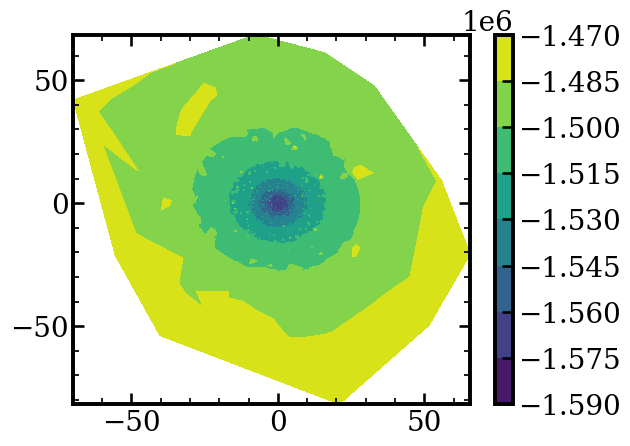

In [33]:
corrected_potential = Potentials - fitted_Z + params[2]
contour=plt.tricontourf(Coordinates[:,0]/kpc2km, Coordinates[:,1]/kpc2km, corrected_potential, cmap='viridis')
plt.colorbar(contour)

In [4]:
ratio,negids,rcs = kinematic_decomp_e2(Coordinates,Velocities,Potentials,HMR)

Number of stars per bin: 166
Nonzero rcs: 27067 Skipped stars: 1


In [5]:
mask = (ratio < 25) & (ratio > -25) & (~np.isnan(ratio))
ratio_masked = ratio[mask]
disks = (ratio_masked > 0.5) & (ratio_masked < 1) 
bulges = ratio_masked < 0.5
Coord = Coordinates[mask]/kpc2km
Bulge = Coord[bulges]
Disk = Coord[disks]

rstars = np.sqrt(Coordinates[:,0]**2 + Coordinates[:,1]**2)

Velocities_masked = Velocities[mask]
disk_vel = Velocities_masked[disks]
bulge_vel = Velocities_masked[bulges]

toobig = ratio > 1
large_ratios = Coordinates[toobig]/kpc2km
masked_rstars = rstars[mask]
len(large_ratios)

10670

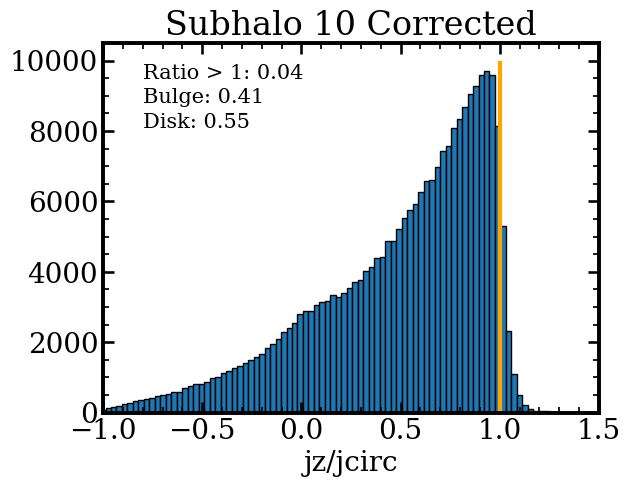

In [9]:
high_ratios = len(large_ratios)/len(ratio)
rbulge = len(Bulge)/len(Coordinates)
rdisk = len(Disk)/len(Coordinates)

plt.hist(ratio_masked,bins=1000,edgecolor='black')
plt.vlines(1,0,10000,color='orange',lw=3)
plt.xlim(-1,1.5)
plt.xlabel('jz/jcirc')
plt.text(-0.8,9500,f'Ratio > 1: {high_ratios:.2f}',size=15)
plt.text(-0.8,8800,f'Bulge: {rbulge:.2f}',size=15)
plt.text(-0.8,8100,f'Disk: {rdisk:.2f}',size=15)

plt.title('Subhalo {} Corrected'.format(subhalo_id))
plt.savefig('Plots/Subhalo_{}_jzjcirc_corrected'.format(subhalo_id))

NameError: name 'gradient_interp' is not defined

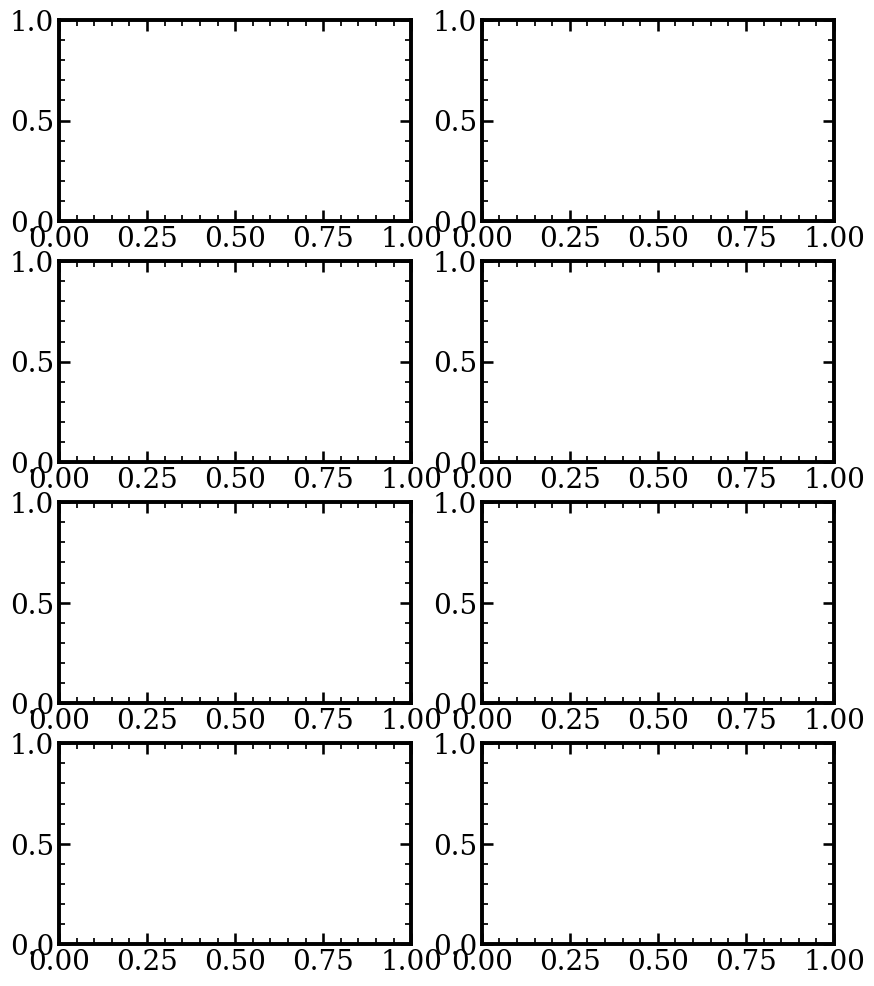

In [10]:
fig,axs = plt.subplots(4,2,figsize=(10,12))

# mask = rstars < 2*HMR*kpc2km
# masked_rstars = rstars[mask]
masked_Potentials = Potentials[mask]
masked_Velocities = Velocities[mask]
interp_g = np.array([gradient_interp(i) for i in masked_rstars])
interp_p = np.array([potental_interp(i) for i in masked_rstars])
vcirc = np.sqrt(masked_rstars * interp_g)

f1 = np.array([interp_p + 0.5*masked_rstars*interp_g])
f2 = masked_Potentials + 0.5*np.linalg.norm(masked_Velocities,axis=1)**2
f2_unmasked = Potentials + 0.5*np.linalg.norm(Velocities,axis=1)**2
f = f1 - f2
toobig_masked = toobig[mask]
high_ratiof = f[0][toobig_masked]

axs[0,0].scatter(np.array(bin_centers)/kpc2km,potential_binned,s = 10)
axs[0,0].set_xlabel("Radius [kpc]",size=12)
axs[0,0].set_ylabel("Potential [$(km^2/s^{2}$]",size=12)
axs[0,0].set_xlim(0,25)

axs[0,1].scatter(pos/kpc2km,grad,s = 10)
axs[0,1].hlines(0,0,np.max(pos)/kpc2km,color='orange')
axs[0,1].set_xlabel("Radius [kpc]",size=12)
axs[0,1].set_ylabel("Potential gradient [$(km/s^{2}$]",size=12)

axs[1,0].scatter(masked_rstars/kpc2km,interp_p,s = 10)
axs[1,0].set_xlabel("Radius [kpc]",size=12)
axs[1,0].set_ylabel("Interpolated potential [$(km^2/s^{2}$]",size=12)

axs[1,1].scatter(masked_rstars/kpc2km,interp_g,s = 10)
axs[1,1].hlines(0,0,np.max(pos)/kpc2km,color='orange')
axs[1,1].set_xlabel("Radius [kpc]",size=12)
axs[1,1].set_ylabel("Interpolated gradient [$(km/s^{2}$]",size=12)

axs[2,0].scatter(masked_rstars/kpc2km,f1,s = 10)
axs[2,0].set_xlabel("Radius [kpc]",size=12)
axs[2,0].set_ylabel("Circular binding e [$(km^2/s^{2}$]",size=12)
# axs[2,0].set_ylim(-1.8e6,-1.4e6)

counts1, xedges1, yedges1, im1 = axs[2,1].hist2d(masked_rstars/kpc2km,f2,norm='log',bins=100)
axs[2,1].scatter(rstars[toobig]/kpc2km,f2_unmasked[toobig],color='red',s=1,label='ratio > 1')
axs[2,1].set_xlabel("Radius [kpc]",size=12)
axs[2,1].set_ylabel("Actual binding e [$(km^2/s^{2}$]",size=12)
axs[2,1].legend(fontsize=10)
# axs[2,1].set_ylim(-1.8e6,-1.4e6)

counts1, xedges1, yedges1, im1 = axs[3,0].hist2d(masked_rstars/kpc2km,f[0],norm='log',bins=100)
axs[3,0].scatter(masked_rstars[toobig_masked]/kpc2km,high_ratiof,s=1,color='red',alpha=0.5)
axs[3,0].set_xlabel("Radius [kpc]",size=12)
axs[3,0].set_ylabel("f [$(km^2/s^{2}$]",size=12)

axs[3,1].scatter(masked_rstars/kpc2km,vcirc,s = 10)
axs[3,1].set_xlabel("Radius [kpc]",size=12)
axs[3,1].set_ylabel("$v_{circ}$ [km/s]",size=12)

fig.suptitle("Subhalo {}".format(subhalo_id))
plt.tight_layout()
plt.savefig('Plots/Subhalo_{}_diagnostics_corrected'.format(subhalo_id))

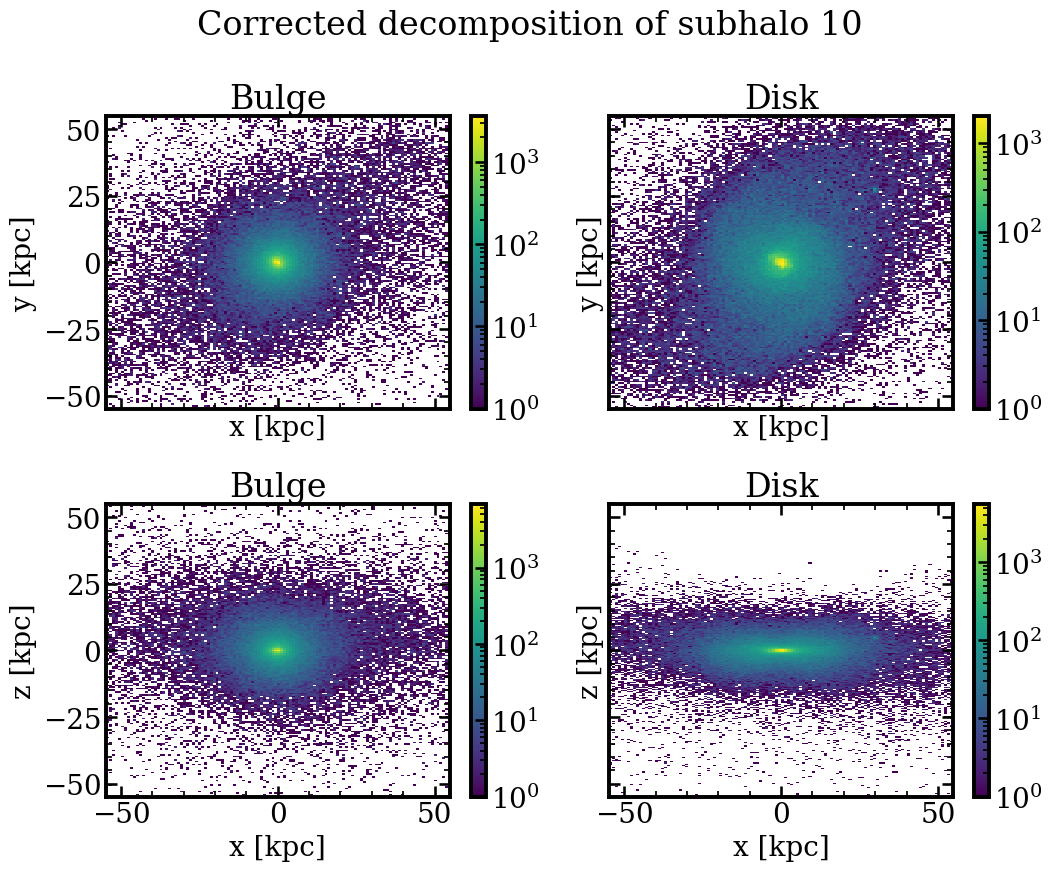

In [11]:
lim = 2*HMR

fig,axs=plt.subplots(2,2,figsize = (11,9),sharex=True,sharey=True)

counts1, xedges1, yedges1, im1 = axs[0,0].hist2d(Bulge[:,0],Bulge[:,1],norm='log',bins=300)
counts2, xedges2, yedges2, im2 = axs[0,1].hist2d(Disk[:,0],Disk[:,1],norm='log',bins=300)
axs[0,0].set_title('Bulge')
axs[0,1].set_title('Disk')
axs[0,0].set_xlabel('x [kpc]')
axs[0,1].set_xlabel('x [kpc]')
axs[0,0].set_ylabel('y [kpc]')
axs[0,1].set_ylabel('y [kpc]')

counts3, xedges3, yedges3, im3 = axs[1,0].hist2d(Bulge[:,0],Bulge[:,2],norm='log',bins=300)
counts4, xedges4, yedges4, im4 = axs[1,1].hist2d(Disk[:,0],Disk[:,2],norm='log',bins=300)

axs[1,0].set_title('Bulge')
axs[1,1].set_title('Disk')
axs[1,0].set_xlabel('x [kpc]')
axs[1,1].set_xlabel('x [kpc]')
axs[1,0].set_ylabel('z [kpc]')
axs[1,1].set_ylabel('z [kpc]')

for ax in axs.flatten():
    ax.set_xlim(-lim,lim)
    ax.set_ylim(-lim,lim)

fig.colorbar(im1, ax=axs[0,0])
fig.colorbar(im2, ax=axs[0,1])
fig.colorbar(im3, ax=axs[1,0])
fig.colorbar(im4, ax=axs[1,1])

fig.suptitle('Corrected decomposition of subhalo {}'.format(subhalo_id))

fig.tight_layout()
fig.savefig('Plots/Subhalo_{}_decomp_corrected.png'.format(subhalo_id))

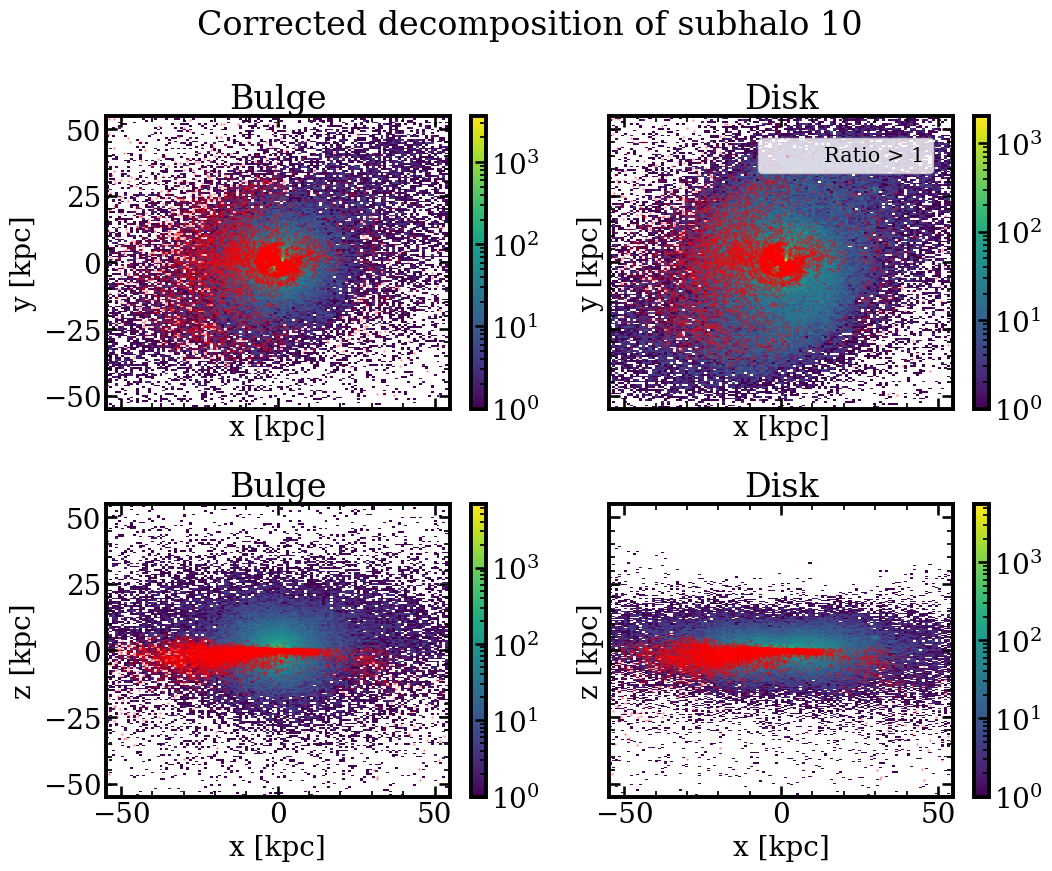

In [12]:
lim = 2*HMR

fig,axs=plt.subplots(2,2,figsize = (11,9),sharex=True,sharey=True)

counts1, xedges1, yedges1, im1 = axs[0,0].hist2d(Bulge[:,0],Bulge[:,1],norm='log',bins=300)
counts2, xedges2, yedges2, im2 = axs[0,1].hist2d(Disk[:,0],Disk[:,1],norm='log',bins=300)
axs[0,0].scatter(large_ratios[:,0],large_ratios[:,1],s=1,color='red',alpha=0.25,label='Ratio > 1')
axs[0,1].scatter(large_ratios[:,0],large_ratios[:,1],s=1,color='red',alpha=0.25)
axs[0,0].set_title('Bulge')
axs[0,1].set_title('Disk')
axs[0,0].set_xlabel('x [kpc]')
axs[0,1].set_xlabel('x [kpc]')
axs[0,0].set_ylabel('y [kpc]')
axs[0,1].set_ylabel('y [kpc]')

counts3, xedges3, yedges3, im3 = axs[1,0].hist2d(Bulge[:,0],Bulge[:,2],norm='log',bins=300)
counts4, xedges4, yedges4, im4 = axs[1,1].hist2d(Disk[:,0],Disk[:,2],norm='log',bins=300)
axs[1,0].scatter(large_ratios[:,0],large_ratios[:,2],s=1,color='red',alpha=0.25)
axs[1,1].scatter(large_ratios[:,0],large_ratios[:,2],s=1,color='red',alpha=0.25)
axs[1,0].set_title('Bulge')
axs[1,1].set_title('Disk')
axs[1,0].set_xlabel('x [kpc]')
axs[1,1].set_xlabel('x [kpc]')
axs[1,0].set_ylabel('z [kpc]')
axs[1,1].set_ylabel('z [kpc]')

for ax in axs.flatten():
    ax.set_xlim(-lim,lim)
    ax.set_ylim(-lim,lim)

fig.colorbar(im1, ax=axs[0,0])
fig.colorbar(im2, ax=axs[0,1])
fig.colorbar(im3, ax=axs[1,0])
fig.colorbar(im4, ax=axs[1,1])

fig.suptitle('Corrected decomposition of subhalo {}'.format(subhalo_id))
fig.legend(fontsize=15,loc=(0.72,0.8))
fig.tight_layout()
fig.savefig('Plots/Subhalo_{}_decomp_corrected_large_ratios.png'.format(subhalo_id))

# Making bins with constant number of stars

In [2]:
TNGpath='/standard/torrey-group/IllustrisTNG/Runs/L75n1820TNG'
basePath = TNGpath
snap_num=99 # z=0
hdr  = il.groupcat.loadHeader(TNGpath, snap_num)
h = hdr['HubbleParam'] ## load in h from the header
box_size = hdr["BoxSize"]
redshift = hdr['Redshift']

In [216]:
subhalo_id = 10 # Desired_subhalos[i] # 31424
# print("Subhalo {}".format(Desired_subhalos[i]))
kpc2km = 3.0857e16
Subhaloprops = il.groupcat.loadSubhalos(basePath,snap_num,fields=['SubhaloPos','SubhaloVel','SubhaloHalfmassRad'])
HMR = Subhaloprops['SubhaloHalfmassRad'][subhalo_id]

fields = ['Masses','Coordinates','Velocities','Potential']
Star_Props = il.snapshot.loadSubhalo(basePath, snap_num, id=subhalo_id, partType=4, fields=fields)

Coordinates,Velocities,Potentials = Center_subhalo(Star_Props,Subhaloprops,box_size,redshift,h,subhalo_id=subhalo_id)

KeyboardInterrupt: 

In [5]:
rstars = np.sqrt(Coordinates[:,0]**2 + Coordinates[:,1]**2)
ro   = HMR*kpc2km # np.percentile(rstars, 97.5)
mask = rstars < ro
rstars_masked = rstars[mask]
potentials_masked = Potentials[mask]

bin_centers,bin_averages = equal_num_bins(rstars_masked,potentials_masked,N=150)
window=15
smoothed_p2 = savgol_filter(bin_averages, window_length=window, polyorder=1)
potental_interp = interp1d(bin_centers, smoothed_p2, kind='linear', fill_value="extrapolate")

xvals = np.linspace(0,ro/kpc2km,150)*kpc2km
yvals = np.array([potental_interp(i) for i in xvals])

grad2 = np.gradient(yvals,xvals)

Number of stars per bin: 17


In [173]:
kpc2km = 3.0857e16 # Conversion rate from kpc to km
# radial distance from subhalo center in the xy plane
r = np.sqrt(Coordinates[:,0]**2 + Coordinates[:,1]**2)

height = 3 * kpc2km # kpc for height of disk
ri   = 0 * kpc2km  # from 0
ro   = HMR*kpc2km # np.percentile(r, 97.5) # to where 97.5% of the stars exist. This prevents large outlier outlier radii from messing up the bins
n = 3 # Number of stars required per bin 

bins = overlapping_bins(ri,ro,nbins=150,dx=0.5)

# Only stars within the height of the disk
disk_mask = (Coordinates[:,2] > -height) & (Coordinates[:,2] < height)
disk_coords = Coordinates[disk_mask]
disk_pot = Potentials[disk_mask]
disk_r = r[disk_mask]    

# Potentials at each radial bin
potential_binned = np.zeros(shape=len(bins))

for i in range(len(bins)):

    # Mask of stars within the current radial bin
    r_mask = (disk_r > bins[i][0]) & (disk_r < bins[i][1])

    # Coordinates, potentials of stars in current bin
    r_bin = disk_coords[r_mask]
    r_pot = disk_pot[r_mask]

    # Require at least n stars in the radial bin to consider the radial potential well-defined
    if len(r_bin) < n:
        potential_binned[i] = np.nan

    # Otherwise, take the average of the potentials in the bin
    else:

        # Calculate mean potential
        potential = np.mean(r_pot)

        # Append to list
        potential_binned[i] = potential
        
no_nans = ~np.isnan(potential_binned)
potential_binned = potential_binned[no_nans]
        
# Positions in the middle of the bins
pos = np.array([np.mean(bins[n]) for n in range(len(bins))])

# Removing nan potential indices from position
pos = pos[no_nans]
window=10
smoothed_p = savgol_filter(potential_binned, window_length=window, polyorder=1)
potental_interp = interp1d(pos, smoothed_p, kind='linear', fill_value="extrapolate")

xvals = np.linspace(0,ro/kpc2km,150)*kpc2km
yvals = np.array([potental_interp(i) for i in xvals])

grad1 = np.gradient(yvals,xvals)

(0.0, 16.50628662109375)

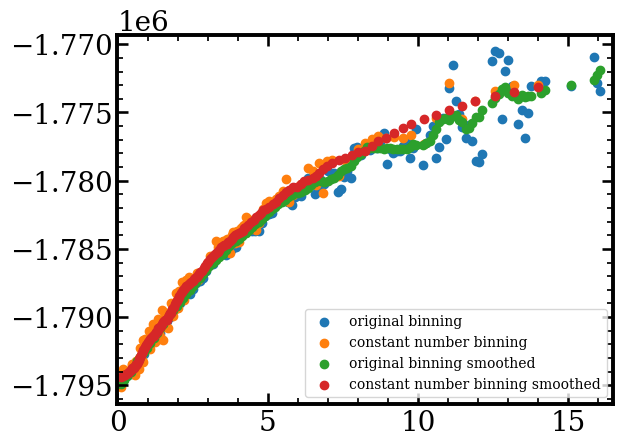

In [174]:
plt.scatter(pos/kpc2km,potential_binned,label='original binning')
plt.scatter(np.array(bin_centers)/kpc2km,bin_averages,label = 'constant number binning')
plt.scatter(pos/kpc2km,smoothed_p,label='original binning smoothed')
plt.scatter(np.array(bin_centers)/kpc2km,smoothed_p2,label = 'constant number binning smoothed')
plt.legend(fontsize=10)
plt.xlim(0,ro/kpc2km)

In [175]:
window=15
smoothed_g1 = savgol_filter(grad1, window_length=window, polyorder=1)
gradient_interp1 = interp1d(xvals, smoothed_g1, kind='linear', fill_value="extrapolate")
smoothed_g2 = savgol_filter(grad2, window_length=window, polyorder=1)
gradient_interp2 = interp1d(xvals, smoothed_g2, kind='linear', fill_value="extrapolate")

interp_g1 = np.array([gradient_interp1(i) for i in xvals])
interp_g2 = np.array([gradient_interp2(i) for i in xvals])

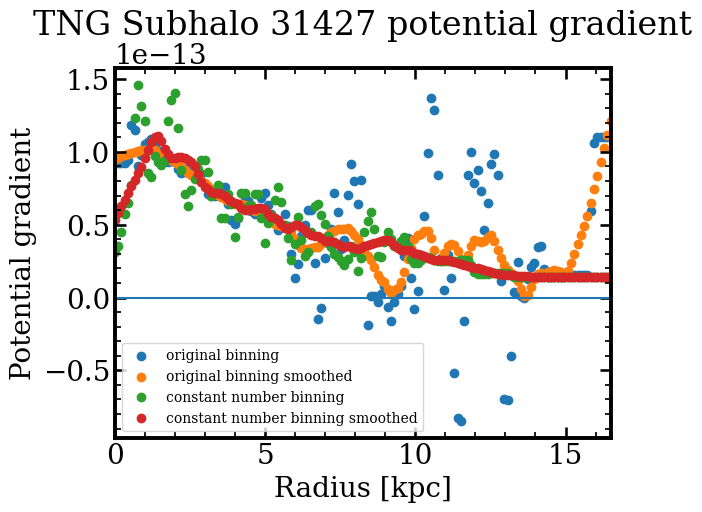

In [176]:
plt.scatter(xvals/kpc2km,grad1,label='original binning')
plt.scatter(xvals/kpc2km,smoothed_g1,label = 'original binning smoothed')
plt.scatter(xvals/kpc2km,grad2,label = 'constant number binning')
plt.scatter(xvals/kpc2km,smoothed_g2,label = 'constant number binning smoothed')
plt.legend(fontsize=10)
plt.ylabel('Potential gradient')
plt.xlabel('Radius [kpc]')
plt.title('TNG Subhalo {} potential gradient'.format(subhalo_id))
plt.hlines(0,0,ro/kpc2km)
plt.xlim(0,ro/kpc2km)
plt.savefig('Plots/TNG_subhalo_{}_pot_grad.png'.format(subhalo_id))

In [217]:
pos,grad,ratio,negids,rcs,bin_centers,potential_binned,gradient_interp,potental_interp = kinematic_decomp_e2(Coordinates,Velocities,Potentials,HMR)

Number of stars per bin: 1004
Nonzero rcs: 255004 Skipped stars: 297


In [218]:
mask = (ratio < 25) & (ratio > -25) & (~np.isnan(ratio))
ratio_masked=ratio[mask]
disks = (ratio_masked > 0.5) & (ratio_masked < 1) 
bulges = ratio_masked < 0.5
Coord = Coordinates[mask]/kpc2km
Bulge = Coord[bulges]
Disk = Coord[disks]

In [219]:
rstars = np.sqrt(Coordinates[:,0]**2 + Coordinates[:,1]**2)

mask = (ratio < 25) & (ratio > -25) & (~np.isnan(ratio))
ratio_masked = ratio[mask]
Velocities_masked = Velocities[mask]

disks = (ratio_masked > 0.5) & (ratio_masked < 1) 
bulges = ratio_masked < 0.5
disk_vel = Velocities_masked[disks]
bulge_vel = Velocities_masked[bulges]

toobig = ratio > 1
large_ratios = Coordinates[toobig]/kpc2km
masked_rstars = rstars[mask]
len(large_ratios)

26417

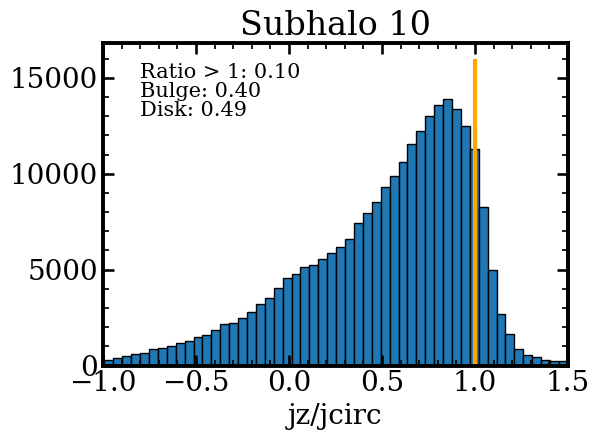

In [223]:
high_ratios = len(large_ratios)/len(ratio)
rbulge = len(Bulge)/len(Coordinates)
rdisk = len(Disk)/len(Coordinates)

plt.hist(ratio_masked,bins=1000,edgecolor='black')
plt.vlines(1,0,16000,color='orange',lw=3)
plt.xlim(-1,1.5)
plt.xlabel('jz/jcirc')
plt.text(-0.8,15000,f'Ratio > 1: {high_ratios:.2f}',size=15)
plt.text(-0.8,14000,f'Bulge: {rbulge:.2f}',size=15)
plt.text(-0.8,13000,f'Disk: {rdisk:.2f}',size=15)

plt.title('Subhalo {}'.format(subhalo_id))
plt.tight_layout()
plt.savefig('Plots/Subhalo_{}_jzjcirc'.format(subhalo_id))

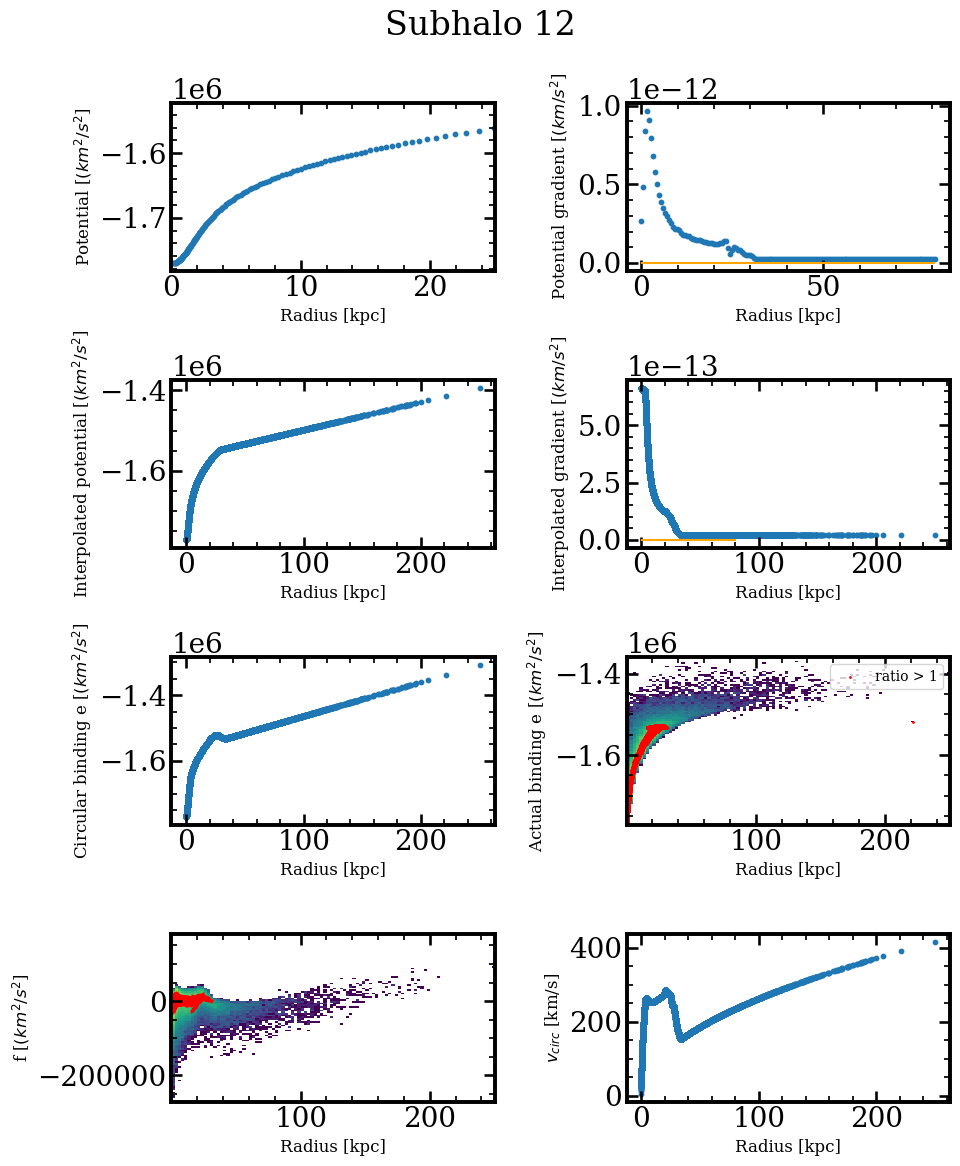

In [92]:
fig,axs = plt.subplots(4,2,figsize=(10,12))

# mask = rstars < 2*HMR*kpc2km
# masked_rstars = rstars[mask]
masked_Potentials = Potentials[mask]
masked_Velocities = Velocities[mask]
interp_g = np.array([gradient_interp(i) for i in masked_rstars])
interp_p = np.array([potental_interp(i) for i in masked_rstars])
vcirc = np.sqrt(masked_rstars * interp_g)

f1 = np.array([interp_p + 0.5*masked_rstars*interp_g])
f2 = masked_Potentials + 0.5*np.linalg.norm(masked_Velocities,axis=1)**2
f2_unmasked = Potentials + 0.5*np.linalg.norm(Velocities,axis=1)**2
f = f1 - f2
toobig_masked = toobig[mask]
high_ratiof = f[0][toobig_masked]

axs[0,0].scatter(np.array(bin_centers)/kpc2km,potential_binned,s = 10)
axs[0,0].set_xlabel("Radius [kpc]",size=12)
axs[0,0].set_ylabel("Potential [$(km^2/s^{2}$]",size=12)
axs[0,0].set_xlim(0,25)

axs[0,1].scatter(pos/kpc2km,grad,s = 10)
axs[0,1].hlines(0,0,np.max(pos)/kpc2km,color='orange')
axs[0,1].set_xlabel("Radius [kpc]",size=12)
axs[0,1].set_ylabel("Potential gradient [$(km/s^{2}$]",size=12)

axs[1,0].scatter(masked_rstars/kpc2km,interp_p,s = 10)
axs[1,0].set_xlabel("Radius [kpc]",size=12)
axs[1,0].set_ylabel("Interpolated potential [$(km^2/s^{2}$]",size=12)

axs[1,1].scatter(masked_rstars/kpc2km,interp_g,s = 10)
axs[1,1].hlines(0,0,np.max(pos)/kpc2km,color='orange')
axs[1,1].set_xlabel("Radius [kpc]",size=12)
axs[1,1].set_ylabel("Interpolated gradient [$(km/s^{2}$]",size=12)

axs[2,0].scatter(masked_rstars/kpc2km,f1,s = 10)
axs[2,0].set_xlabel("Radius [kpc]",size=12)
axs[2,0].set_ylabel("Circular binding e [$(km^2/s^{2}$]",size=12)
# axs[2,0].set_ylim(-1.8e6,-1.4e6)

counts1, xedges1, yedges1, im1 = axs[2,1].hist2d(masked_rstars/kpc2km,f2,norm='log',bins=100)
axs[2,1].scatter(rstars[toobig]/kpc2km,f2_unmasked[toobig],color='red',s=1,label='ratio > 1')
axs[2,1].set_xlabel("Radius [kpc]",size=12)
axs[2,1].set_ylabel("Actual binding e [$(km^2/s^{2}$]",size=12)
axs[2,1].legend(fontsize=10)
# axs[2,1].set_ylim(-1.8e6,-1.4e6)

counts1, xedges1, yedges1, im1 = axs[3,0].hist2d(masked_rstars/kpc2km,f[0],norm='log',bins=100)
axs[3,0].scatter(masked_rstars[toobig_masked]/kpc2km,high_ratiof,s=1,color='red',alpha=0.5)
axs[3,0].set_xlabel("Radius [kpc]",size=12)
axs[3,0].set_ylabel("f [$(km^2/s^{2}$]",size=12)

axs[3,1].scatter(masked_rstars/kpc2km,vcirc,s = 10)
axs[3,1].set_xlabel("Radius [kpc]",size=12)
axs[3,1].set_ylabel("$v_{circ}$ [km/s]",size=12)

fig.suptitle("Subhalo {}".format(subhalo_id))
plt.tight_layout()
plt.savefig('Plots/Subhalo_{}_diagnostics_2'.format(subhalo_id))

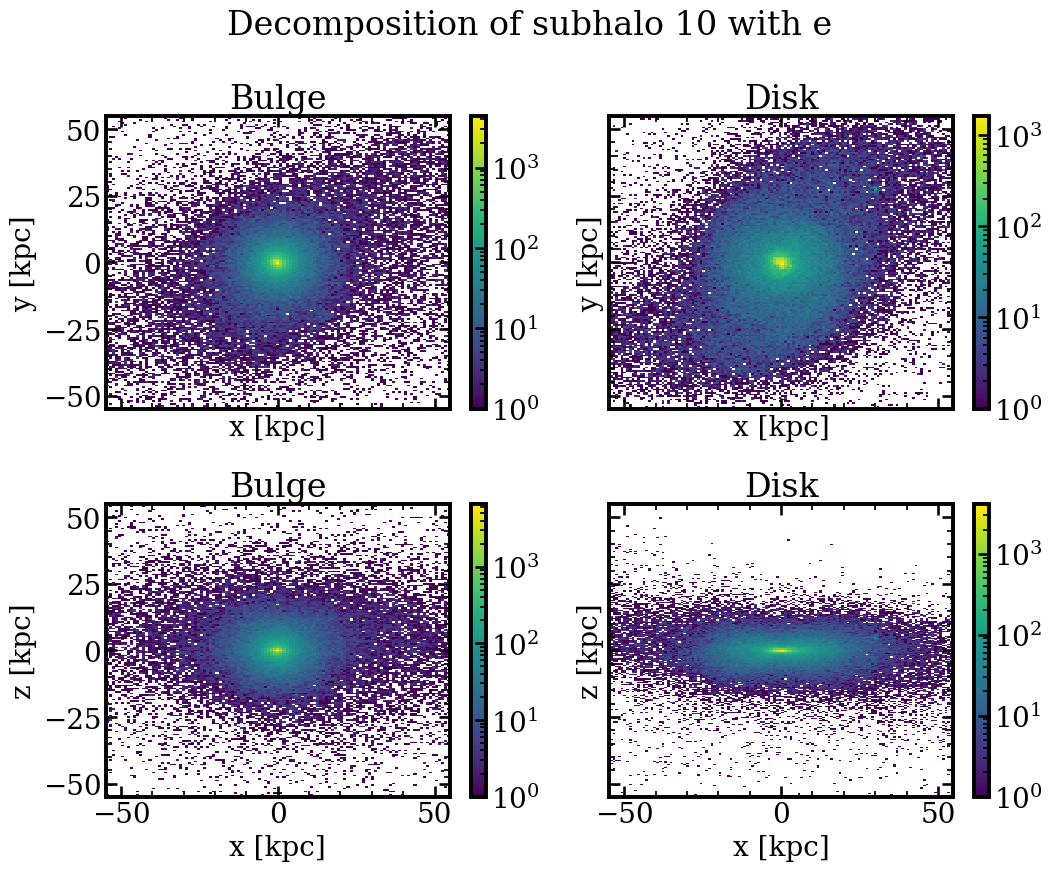

In [221]:
Coord = Coordinates[mask]/kpc2km
Bulge = Coord[bulges]
Disk = Coord[disks]
lim = 2*HMR

fig,axs=plt.subplots(2,2,figsize = (11,9),sharex=True,sharey=True)

counts1, xedges1, yedges1, im1 = axs[0,0].hist2d(Bulge[:,0],Bulge[:,1],norm='log',bins=300)
counts2, xedges2, yedges2, im2 = axs[0,1].hist2d(Disk[:,0],Disk[:,1],norm='log',bins=300)
# axs[0,0].scatter(large_ratios[:,0],large_ratios[:,1],s=1,color='red',alpha=0.25,label='Ratio > 1')
# axs[0,1].scatter(large_ratios[:,0],large_ratios[:,1],s=1,color='red',alpha=0.25)
axs[0,0].set_title('Bulge')
axs[0,1].set_title('Disk')
axs[0,0].set_xlabel('x [kpc]')
axs[0,1].set_xlabel('x [kpc]')
axs[0,0].set_ylabel('y [kpc]')
axs[0,1].set_ylabel('y [kpc]')

counts3, xedges3, yedges3, im3 = axs[1,0].hist2d(Bulge[:,0],Bulge[:,2],norm='log',bins=300)
counts4, xedges4, yedges4, im4 = axs[1,1].hist2d(Disk[:,0],Disk[:,2],norm='log',bins=300)
# axs[1,0].scatter(large_ratios[:,0],large_ratios[:,2],s=1,color='red',alpha=0.25)
# axs[1,1].scatter(large_ratios[:,0],large_ratios[:,2],s=1,color='red',alpha=0.25)

axs[1,0].set_title('Bulge')
axs[1,1].set_title('Disk')
axs[1,0].set_xlabel('x [kpc]')
axs[1,1].set_xlabel('x [kpc]')
axs[1,0].set_ylabel('z [kpc]')
axs[1,1].set_ylabel('z [kpc]')

for ax in axs.flatten():
    ax.set_xlim(-lim,lim)
    ax.set_ylim(-lim,lim)

fig.colorbar(im1, ax=axs[0,0])
fig.colorbar(im2, ax=axs[0,1])
fig.colorbar(im3, ax=axs[1,0])
fig.colorbar(im4, ax=axs[1,1])

fig.suptitle('Decomposition of subhalo {} with e'.format(subhalo_id))
fig.tight_layout()
fig.savefig('Plots/Subhalo_{}_decomp.png'.format(subhalo_id))

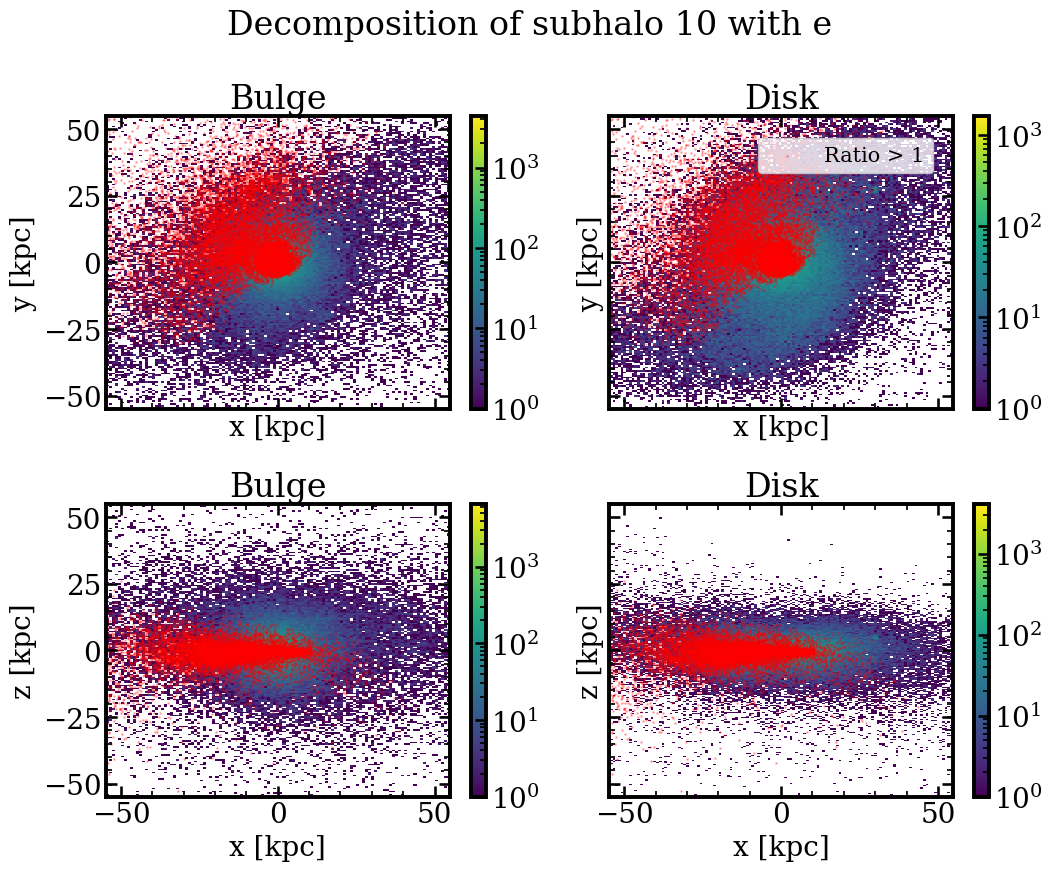

In [222]:
Coord = Coordinates[mask]/kpc2km
Bulge = Coord[bulges]
Disk = Coord[disks]
lim = 2*HMR

fig,axs=plt.subplots(2,2,figsize = (11,9),sharex=True,sharey=True)

counts1, xedges1, yedges1, im1 = axs[0,0].hist2d(Bulge[:,0],Bulge[:,1],norm='log',bins=300)
counts2, xedges2, yedges2, im2 = axs[0,1].hist2d(Disk[:,0],Disk[:,1],norm='log',bins=300)
axs[0,0].scatter(large_ratios[:,0],large_ratios[:,1],s=1,color='red',alpha=0.25,label='Ratio > 1')
axs[0,1].scatter(large_ratios[:,0],large_ratios[:,1],s=1,color='red',alpha=0.25)
axs[0,0].set_title('Bulge')
axs[0,1].set_title('Disk')
axs[0,0].set_xlabel('x [kpc]')
axs[0,1].set_xlabel('x [kpc]')
axs[0,0].set_ylabel('y [kpc]')
axs[0,1].set_ylabel('y [kpc]')

counts3, xedges3, yedges3, im3 = axs[1,0].hist2d(Bulge[:,0],Bulge[:,2],norm='log',bins=300)
counts4, xedges4, yedges4, im4 = axs[1,1].hist2d(Disk[:,0],Disk[:,2],norm='log',bins=300)
axs[1,0].scatter(large_ratios[:,0],large_ratios[:,2],s=1,color='red',alpha=0.25)
axs[1,1].scatter(large_ratios[:,0],large_ratios[:,2],s=1,color='red',alpha=0.25)

axs[1,0].set_title('Bulge')
axs[1,1].set_title('Disk')
axs[1,0].set_xlabel('x [kpc]')
axs[1,1].set_xlabel('x [kpc]')
axs[1,0].set_ylabel('z [kpc]')
axs[1,1].set_ylabel('z [kpc]')

for ax in axs.flatten():
    ax.set_xlim(-lim,lim)
    ax.set_ylim(-lim,lim)

fig.colorbar(im1, ax=axs[0,0])
fig.colorbar(im2, ax=axs[0,1])
fig.colorbar(im3, ax=axs[1,0])
fig.colorbar(im4, ax=axs[1,1])

fig.suptitle('Decomposition of subhalo {} with e'.format(subhalo_id))
fig.legend(fontsize=15,loc=(0.72,0.8))
fig.tight_layout()
fig.savefig('Plots/Subhalo_{}_decomp_large_ratios.png'.format(subhalo_id))

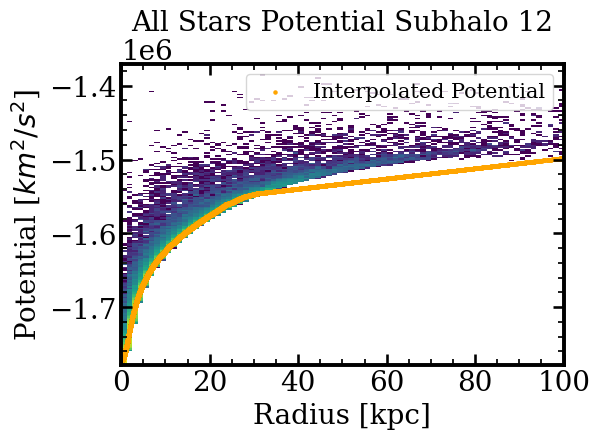

In [95]:
counts1, xedges1, yedges1, im1 = plt.hist2d(np.array(rstars)/kpc2km,Potentials,norm='log',bins=(200,200))
plt.scatter(masked_rstars/kpc2km,interp_p,s=5,color='orange',label = 'Interpolated Potential')
plt.xlim(0,100)
# plt.ylim(-1.59e6,-1.45e6)
plt.xlabel('Radius [kpc]')
plt.ylabel('Potential [$km^2/s^2$]')
plt.legend(fontsize=15)
plt.title('All Stars Potential Subhalo {}'.format(subhalo_id),size=20)
plt.tight_layout()
plt.savefig('Plots/Subhalo_{}_all_stars_pot'.format(subhalo_id))

ValueError: x and y must be the same size

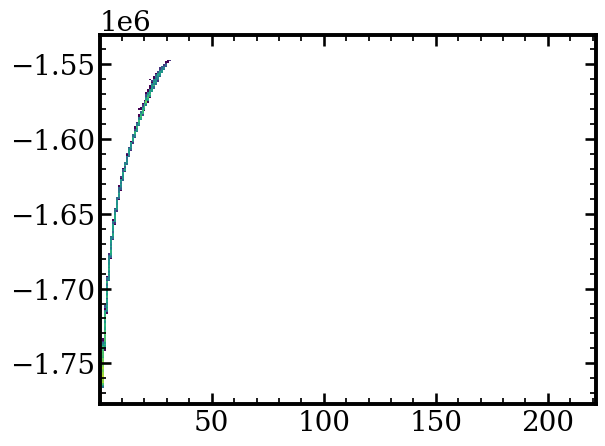

In [193]:
Potentials2big = Potentials[toobig]
rstars_2big = rstars[toobig]

counts1, xedges1, yedges1, im1 = plt.hist2d(np.array(rstars_2big)/kpc2km,Potentials2big,norm='log',bins=(250,250))
plt.scatter(masked_rstars/kpc2km,interp_p,s=5,color='orange',label = 'Interpolated Potential')
plt.xlim(0,50)
# plt.ylim(-1.59e6,-1.45e6)
plt.xlabel('Radius [kpc]')
plt.ylabel('Potential [$km^2/s^2$]')
plt.legend(fontsize=15)
plt.title('High Ratio Potential Subhalo {}'.format(subhalo_id),size=20)
plt.tight_layout()
plt.savefig('Plots/Subhalo_{}_high_ratio_pot'.format(subhalo_id))

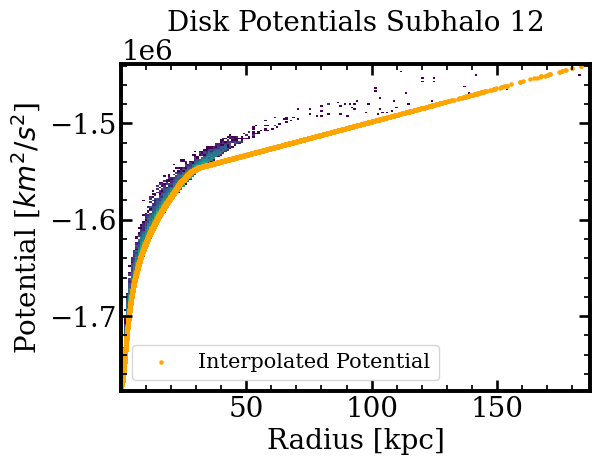

In [117]:
Potentialsmasked = Potentials[mask]

counts1, xedges1, yedges1, im1 = plt.hist2d(np.array(masked_rstars[disks])/kpc2km,Potentialsmasked[disks],norm='log',bins=(200,200))
plt.scatter(masked_rstars/kpc2km,interp_p,s=5,color='orange',label = 'Interpolated Potential')
# plt.xlim(0,40)
# plt.ylim(-1.59e6,-1.45e6)
plt.xlabel('Radius [kpc]')
plt.ylabel('Potential [$km^2/s^2$]')
plt.legend(fontsize=15)
plt.title('Disk Potentials Subhalo {}'.format(subhalo_id),size=20)
plt.tight_layout()
plt.savefig('Plots/Subhalo_{}_disk_pot'.format(subhalo_id))

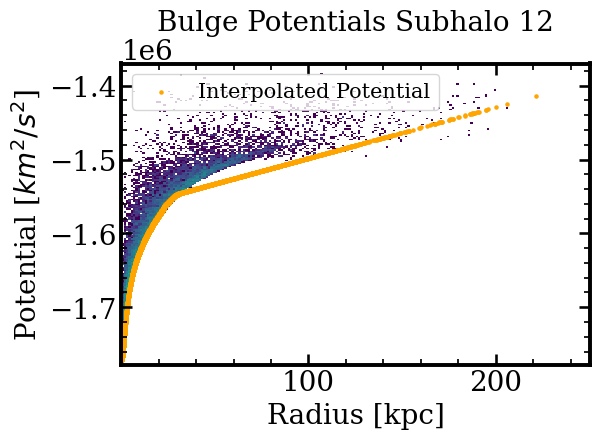

In [118]:
Potentialsmasked = Potentials[mask]

counts1, xedges1, yedges1, im1 = plt.hist2d(np.array(masked_rstars[bulges])/kpc2km,Potentialsmasked[bulges],norm='log',bins=(200,200))
plt.scatter(masked_rstars/kpc2km,interp_p,s=5,color='orange',label = 'Interpolated Potential')
# plt.xlim(0,40)
# plt.ylim(-1.59e6,-1.45e6)
plt.xlabel('Radius [kpc]')
plt.ylabel('Potential [$km^2/s^2$]')
plt.legend(fontsize=15)
plt.title('Bulge Potentials Subhalo {}'.format(subhalo_id),size=20)
plt.tight_layout()
plt.savefig('Plots/Subhalo_{}_bulge_pot'.format(subhalo_id))

Number of stars per bin: 600


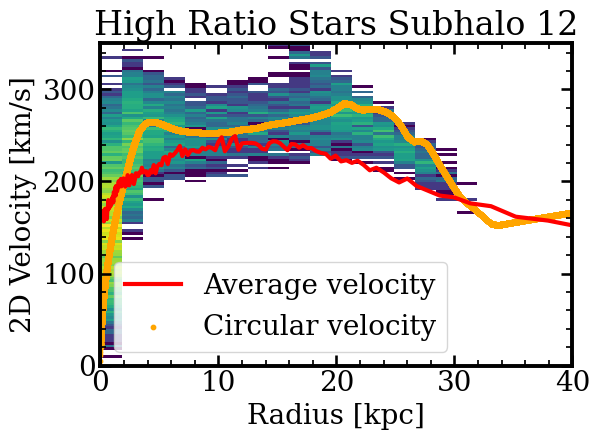

In [121]:
rstars = np.sqrt(Coordinates[:,0]**2 + Coordinates[:,1]**2)
vel2d = np.sqrt(Velocities[:,0]**2 + Velocities[:,1]**2)
rstars_2big = rstars[toobig]
vel2d2big = vel2d[toobig]

bin_centers,bin_averages = equal_num_bins(rstars,vel2d,N=150)
plt.plot(np.array(bin_centers)/kpc2km,bin_averages,color='red',lw=3,label = 'Average velocity')
counts1, xedges1, yedges1, im1 = plt.hist2d(np.array(rstars_2big)/kpc2km,vel2d2big,norm='log',bins=(125,125))
plt.scatter(masked_rstars/kpc2km,vcirc,s=10,color='orange',label='Circular velocity')
plt.xlabel('Radius [kpc]')
plt.ylabel('2D Velocity [km/s]')
plt.legend()
plt.xlim(0,40)
plt.ylim(0,350)
plt.title('High Ratio Stars Subhalo {}'.format(subhalo_id))
plt.tight_layout()
plt.savefig('Plots/Subhalo_{}_high_ratio_vels'.format(subhalo_id))

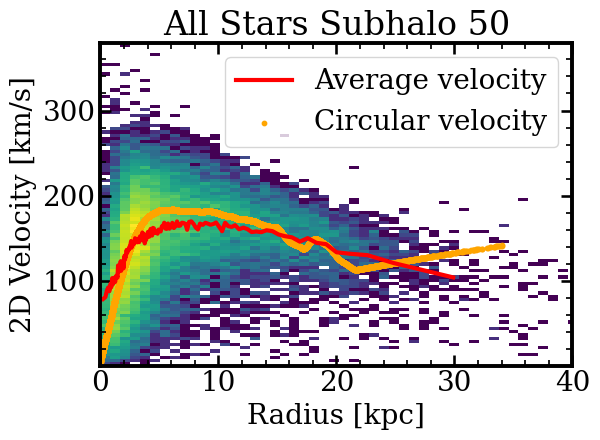

In [15]:
plt.plot(np.array(bin_centers)/kpc2km,bin_averages,color='red',lw=3,label = 'Average velocity')
counts1, xedges1, yedges1, im1 = plt.hist2d(np.array(rstars)/kpc2km,vel2d,norm='log',bins=(100,100))
plt.scatter(masked_rstars/kpc2km,vcirc,s=10,color='orange',label='Circular velocity')
plt.xlabel('Radius [kpc]')
plt.ylabel('2D Velocity [km/s]')
plt.legend()
plt.xlim(0,40)
plt.title('All Stars Subhalo {}'.format(subhalo_id))
plt.tight_layout()
plt.savefig('Plots/Subhalo_{}_all_vels'.format(subhalo_id))

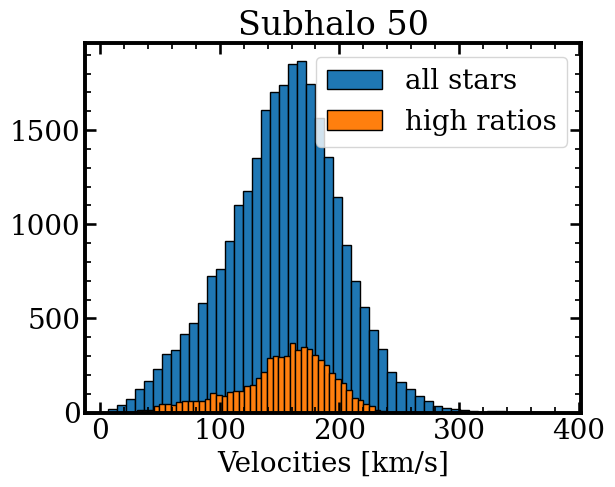

In [159]:
vel3d = np.linalg.norm(Velocities,axis=1)
high_ratio_vels = vel3d[toobig]
plt.hist(vel3d,bins=50,edgecolor='black',label='all stars')
plt.hist(high_ratio_vels,bins=50,edgecolor='black',label='high ratios')
plt.legend()
plt.xlabel('Velocities [km/s]')
plt.title('Subhalo {}'.format(subhalo_id))
plt.savefig('Plots/Subhalo_{}_velocities'.format(subhalo_id))

# Testing on BRAHMA subhalos now:

In [2]:
path_to_output='/standard/torrey-group/BRAHMA/L12p5n512' # this is the folder containing the simulation run
run='/AREPO/' # name of the simulation runs
output='output_ratio10_SFMFGM5_seed5.00_bFOF/' # Name of the box we want to load data from
basePath = path_to_output+run+output # Combining paths to read data in 
file_format='fof_subfind'
desired_redshift=0
kpc2km=3.0857e16

In [3]:
SubhaloLenType,o = arepo_package.get_subhalo_property(basePath,'SubhaloLenType',desired_redshift,postprocessed=1)
SubhaloBHLen = SubhaloLenType[:,5]
SubhaloStarsLen = SubhaloLenType[:,4]
SubhaloIndices = np.arange(0,len(SubhaloBHLen))
mask1 = np.logical_and(SubhaloBHLen>0,SubhaloStarsLen>1000)  # Only subhalos with a BH and with 1000 stars
mask2 = SubhaloStarsLen>10                # Only subhalos with stars; want another array of values for a Mstar-msigma plot

SubhaloIndicesWithBH = SubhaloIndices[mask1] # Return these so we can cross-reference which subhalos to plot
SubhaloIndicesWithStars = SubhaloIndices[mask2]

In [4]:
snap_num=32 # z=0
hdr  = il.groupcat.loadHeader(basePath, snap_num)
h = hdr['HubbleParam'] ## load in h from the header
box_size = hdr['BoxSize']
redshift = hdr['Redshift']

In [5]:
output_redshift,output_snapshot=arepo_package.desired_redshift_to_output_redshift(basePath,
                                                                    desired_redshift,list_all=False,file_format=file_format)
Stellar_vel=il.snapshot.loadSubset_groupordered(basePath,output_snapshot,partType=4,fields='Velocities')
Stellar_pos=il.snapshot.loadSubset_groupordered(basePath,output_snapshot,partType=4,fields='Coordinates')
Stellar_pot=il.snapshot.loadSubset_groupordered(basePath,output_snapshot,partType=4,fields='Potential')
Stellar_mass=il.snapshot.loadSubset_groupordered(basePath,output_snapshot,partType=4,fields='Masses')
# requested_property3=il.snapshot.loadSubset_groupordered(basePath,output_snapshot,partType=5,fields='BH_Mass')
# requested_property4=il.snapshot.loadSubset_groupordered(basePath,output_snapshot,partType=5,fields='BH_Progs')
# requested_property5=il.snapshot.loadSubset_groupordered(basePath,output_snapshot,partType=5,fields='ParticleIDs')
# requested_property6=il.snapshot.loadSubset_groupordered(basePath,output_snapshot,partType=5,fields='BH_Mdot')
# requested_property7=il.snapshot.loadSubset_groupordered(basePath,output_snapshot,partType=5,fields='Velocities')

# Grabbing stellar age; negative ages are wind particles that should not be included in sigma calculation
Age=il.snapshot.loadSubset_groupordered(basePath,output_snapshot,partType=4,fields='GFM_StellarFormationTime')

# Subhalo properties
Subhaloprops,o =  arepo_package.get_subhalo_property(basePath,['SubhaloVel','SubhaloPos','SubhaloHalfmassRad'],desired_redshift,postprocessed=1)

# Scale factor calculation for unit corrections
a = 1/(1+output_redshift)

In [21]:
(np.sum(Star_Props['Masses'])*1e10/h)

4121588562.038761

In [18]:
Velocities_3d = np.linalg.norm(Velocities,axis=1)
Velocities_3d

array([ 13.205638 ,   7.2385597,  23.250513 , ..., 112.013535 ,
       121.57109  , 123.65585  ], dtype=float32)

In [19]:
np.std(Velocities_3d)

30.844166

In [15]:
np.std(bulge_vel_3d)

37.1221

In [14]:
bulge_vel_3d = np.linalg.norm(bulge_vel,axis=1)
bulge_vel_3d

array([ 17.795057,  22.356544,  27.245073, ..., 112.013535, 121.57109 ,
       123.65585 ], dtype=float32)

In [6]:
index = SubhaloIndicesWithBH[54]

Vel_subhalo,Vel_group,output_redshift=get_particle_property_within_postprocessed_groups_adj(basePath,'Velocities',4,output_redshift,index,Stellar_vel,store_all_offsets=1,group_type='subhalo')
pos_subhalo,pos_group,output_redshift=get_particle_property_within_postprocessed_groups_adj(basePath,'Coordinates',4,output_redshift,index,Stellar_pos,store_all_offsets=1,group_type='subhalo')
pot_subhalo,pot_group,output_redshift=get_particle_property_within_postprocessed_groups_adj(basePath,'Potential',4,output_redshift,index,Stellar_pot,store_all_offsets=1,group_type='subhalo')
mstar_subhalo,mstar_group,output_redshift=get_particle_property_within_postprocessed_groups_adj(basePath,'Masses',4,output_redshift,index,Stellar_mass,store_all_offsets=1,group_type='subhalo')
Star_Props = {'Masses':mstar_subhalo,'Coordinates':pos_subhalo,'Velocities':Vel_subhalo,'Potential':pot_subhalo}
# Subhaloprops = {'SubhaloVel':Subhaloprops['SubhaloVel'][index],'SubhaloPos':Subhaloprops['SubhaloPos'][index]}
HMR = Subhaloprops['SubhaloHalfmassRad'][index]

Coordinates,Velocities,Potentials = Center_subhalo(Star_Props,Subhaloprops,box_size,redshift,h,subhalo_id=index)
# pos,grad,ratio2,negids,rcs,potential_binned,gradient_interp,potental_interp = kinematic_decomp_e(Coordinates,Velocities,Potentials)

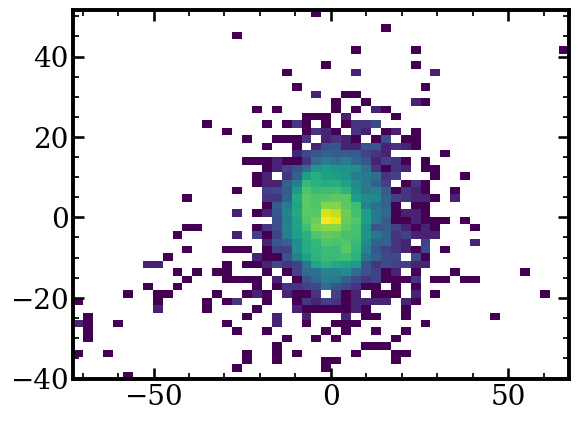

In [75]:
pltcounts1, xedges1, yedges1, im1 = plt.hist2d(Coordinates[:,0]/kpc2km,Coordinates[:,1]/kpc2km,norm='log',bins=50)

In [8]:
ratio,negids,rcs = kinematic_decomp_e2(Coordinates,Velocities,Potentials,HMR)

Number of stars per bin: 110
Nonzero rcs: 19099 Skipped stars: 1


In [9]:
mask = (ratio < 25) & (ratio > -25) & (~np.isnan(ratio))
ratio_masked = ratio[mask]
disks = (ratio_masked > 0.5) & (ratio_masked < 1) 
bulges = ratio_masked < 0.5
Coord = Coordinates[mask]/kpc2km
Bulge = Coord[bulges]
Disk = Coord[disks]

rstars = np.sqrt(Coordinates[:,0]**2 + Coordinates[:,1]**2)

Velocities_masked = Velocities[mask]
disk_vel = Velocities_masked[disks]
bulge_vel = Velocities_masked[bulges]

toobig = ratio > 1
large_ratios = Coordinates[toobig]/kpc2km
masked_rstars = rstars[mask]
len(large_ratios)

1715

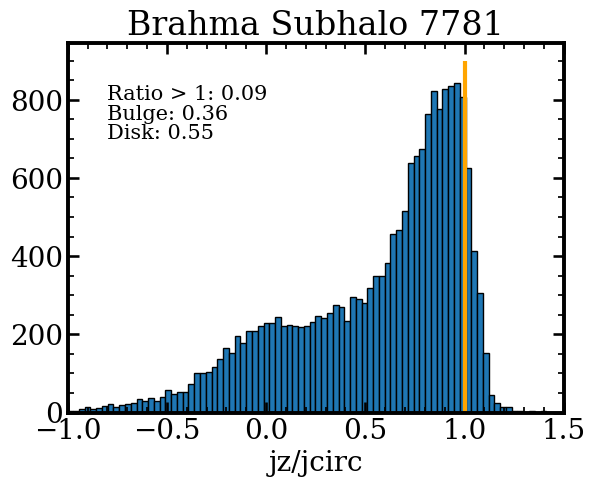

In [81]:
high_ratios = len(large_ratios)/len(ratio)
rbulge = len(Bulge)/len(Coordinates)
rdisk = len(Disk)/len(Coordinates)

plt.hist(ratio_masked,bins=300,edgecolor='black')
plt.vlines(1,0,900,color='orange',lw=3)
plt.xlim(-1,1.5)
plt.xlabel('jz/jcirc')
plt.text(-0.8,800,f'Ratio > 1: {high_ratios:.2f}',size=15)
plt.text(-0.8,750,f'Bulge: {rbulge:.2f}',size=15)
plt.text(-0.8,700,f'Disk: {rdisk:.2f}',size=15)

plt.title('Brahma Subhalo {}'.format(index))
plt.savefig('Plots/Brahma_Subhalo_{}_jzjcirc'.format(index))

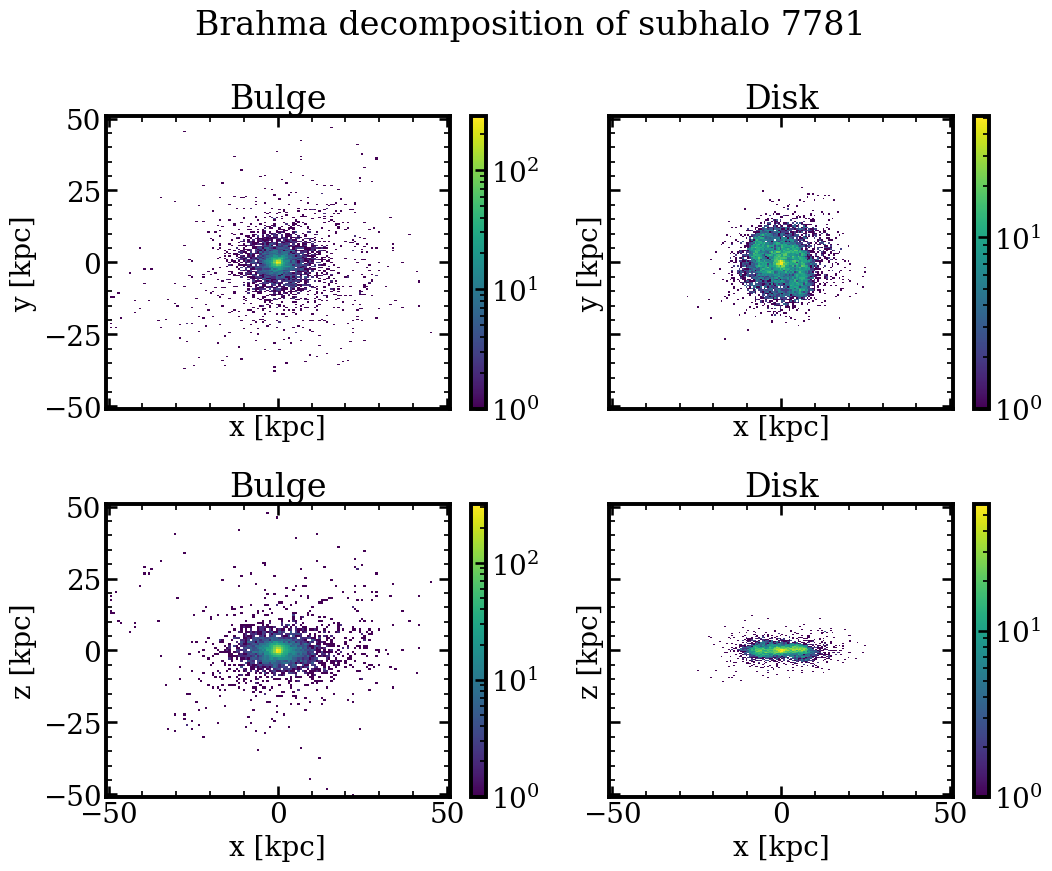

In [82]:
lim = 2*HMR

fig,axs=plt.subplots(2,2,figsize = (11,9),sharex=True,sharey=True)

counts1, xedges1, yedges1, im1 = axs[0,0].hist2d(Bulge[:,0],Bulge[:,1],norm='log',bins=200)
counts2, xedges2, yedges2, im2 = axs[0,1].hist2d(Disk[:,0],Disk[:,1],norm='log',bins=100)
axs[0,0].set_title('Bulge')
axs[0,1].set_title('Disk')
axs[0,0].set_xlabel('x [kpc]')
axs[0,1].set_xlabel('x [kpc]')
axs[0,0].set_ylabel('y [kpc]')
axs[0,1].set_ylabel('y [kpc]')

counts3, xedges3, yedges3, im3 = axs[1,0].hist2d(Bulge[:,0],Bulge[:,2],norm='log',bins=200)
counts4, xedges4, yedges4, im4 = axs[1,1].hist2d(Disk[:,0],Disk[:,2],norm='log',bins=100)

axs[1,0].set_title('Bulge')
axs[1,1].set_title('Disk')
axs[1,0].set_xlabel('x [kpc]')
axs[1,1].set_xlabel('x [kpc]')
axs[1,0].set_ylabel('z [kpc]')
axs[1,1].set_ylabel('z [kpc]')

for ax in axs.flatten():
    ax.set_xlim(-lim,lim)
    ax.set_ylim(-lim,lim)

fig.colorbar(im1, ax=axs[0,0])
fig.colorbar(im2, ax=axs[0,1])
fig.colorbar(im3, ax=axs[1,0])
fig.colorbar(im4, ax=axs[1,1])

fig.suptitle('Brahma decomposition of subhalo {}'.format(index))

fig.tight_layout()
fig.savefig('Plots/Brahma_Subhalo_{}_decomp.png'.format(index))

In [10]:
disk_vel_3d = np.linalg.norm(disk_vel,axis=1)
bulge_vel_3d = np.linalg.norm(bulge_vel,axis=1)

<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_63943/2747597077.py:5: SyntaxWarning: invalid escape sequence '\s'
  plt.text(-150,650,f"$\sigma:${np.std(disk_vel_3d):.2f} km/s",size=15)


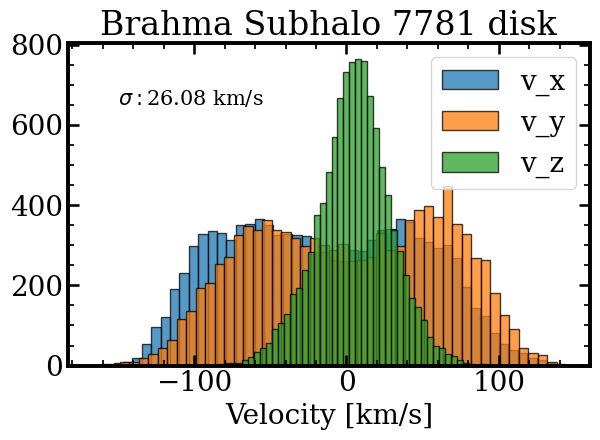

In [12]:
plt.hist(disk_vel[:,0],bins=50,edgecolor='black',label = 'v_x',alpha=0.75)
plt.hist(disk_vel[:,1],bins=50,edgecolor='black',label = 'v_y',alpha=0.75)
plt.hist(disk_vel[:,2],bins=50,edgecolor='black',label = 'v_z',alpha=0.75)

plt.text(-150,650,f"$\sigma:${np.std(disk_vel_3d):.2f} km/s",size=15)
plt.legend(loc=1)
plt.title("Brahma Subhalo {} disk".format(index))
plt.xlabel("Velocity [km/s]")
plt.tight_layout()
plt.savefig('Plots/Brahma_Subhalo_{}_vel_disk.png'.format(index))

<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_63943/2641714754.py:5: SyntaxWarning: invalid escape sequence '\s'
  plt.text(-170,450,f"$\sigma:${np.std(bulge_vel_3d):.2f} km/s",size=15)


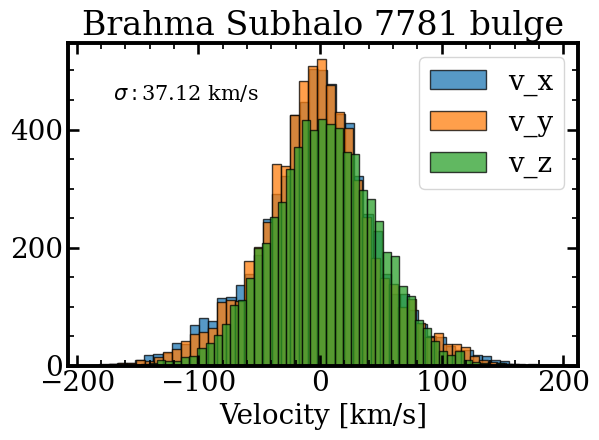

In [13]:
plt.hist(bulge_vel[:,0],bins=50,edgecolor='black',label = 'v_x',alpha=0.75)
plt.hist(bulge_vel[:,1],bins=50,edgecolor='black',label = 'v_y',alpha=0.75)
plt.hist(bulge_vel[:,2],bins=50,edgecolor='black',label = 'v_z',alpha=0.75)

plt.text(-170,450,f"$\sigma:${np.std(bulge_vel_3d):.2f} km/s",size=15)
plt.legend()
plt.title("Brahma Subhalo {} bulge".format(index))
plt.xlabel("Velocity [km/s]")
plt.tight_layout()
plt.savefig('Plots/Brahma_Subhalo_{}_vel_bulge.png'.format(index))

# Testing code:

In [20]:
TNGpath='/standard/torrey-group/IllustrisTNG/Runs/L75n1820TNG'
basePath = TNGpath
snap_num=99 # z=0
hdr  = il.groupcat.loadHeader(TNGpath, snap_num)
h = hdr['HubbleParam'] ## load in h from the header
box_size = hdr["BoxSize"]
redshift = hdr['Redshift']

In [9]:
fields=['SubhaloLenType']

Subhalo_lengths = il.groupcat.loadSubhalos(basePath,snap_num,fields=fields)
SubhaloBHLen = Subhalo_lengths[:,5] # Number of BHs in each subhalo
SubhaloStarsLen = Subhalo_lengths[:,4] # Number of Stars in each subhalo
SubhaloIndices = np.arange(0,len(SubhaloBHLen)) # Indices of subhalos
mask1 = np.logical_and(SubhaloBHLen>0,SubhaloStarsLen>1000)  # Only subhalos with a BH and with 1000 stars
Desired_subhalos = SubhaloIndices[mask1]

In [ ]:
# for i in range(40,100):
subhalo_id = 12 # Desired_subhalos[i] # 31424
# print("Subhalo {}".format(Desired_subhalos[i]))
kpc2km = 3.0857e16
Subhaloprops = il.groupcat.loadSubhalos(basePath,snap_num,fields=['SubhaloPos','SubhaloVel'])
fields = ['Masses','Coordinates','Velocities','Potential']
Star_Props = il.snapshot.loadSubhalo(basePath, snap_num, id=subhalo_id, partType=4, fields=fields)

Coordinates,Velocities,Potentials = Center_subhalo(Star_Props,Subhaloprops,box_size,redshift,h,subhalo_id=subhalo_id)


pos,grad,ratio2,negids,rcs,potential_binned,gradient_interp,potental_interp = kinematic_decomp_e(Coordinates,Velocities,Potentials)

e_bind = 0.5*np.linalg.norm(np.array(Velocities)**2,axis=1) + Potentials

# Normalizing to max binding energy
e_bind_norm = e_bind/np.abs(np.min(e_bind))

pos /= kpc2km

In [ ]:
mask = (ratio2 < 25) & (ratio2 > -25) & (~np.isnan(ratio2))
ratio2 = ratio2[mask]
plt.hist(ratio2,bins=500,edgecolor='black')
plt.xlim(-1,1.2)

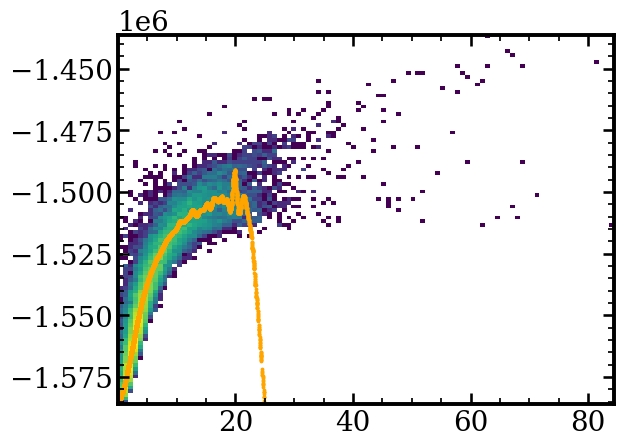

In [22]:
rstars = np.sqrt(Coordinates[:,0]**2 + Coordinates[:,1]**2)
mask = rstars < 25*kpc2km
masked_rstars = rstars[mask]
masked_Potentials = Potentials[mask]
masked_Velocities = Velocities[mask]
interp_g = np.array([gradient_interp(i) for i in masked_rstars])
interp_p = np.array([potental_interp(i) for i in masked_rstars])
f1 = np.array([interp_p + 0.5*masked_rstars*interp_g])

vals = [Potentials[i] + 0.5*np.linalg.norm(Velocities[i])**2 for i in range(len(Potentials))]
counts1, xedges1, yedges1, im1 = plt.hist2d(rstars/kpc2km,vals,norm='log',bins=100)
plt.scatter(masked_rstars/kpc2km,f1,s = 3,color='orange')


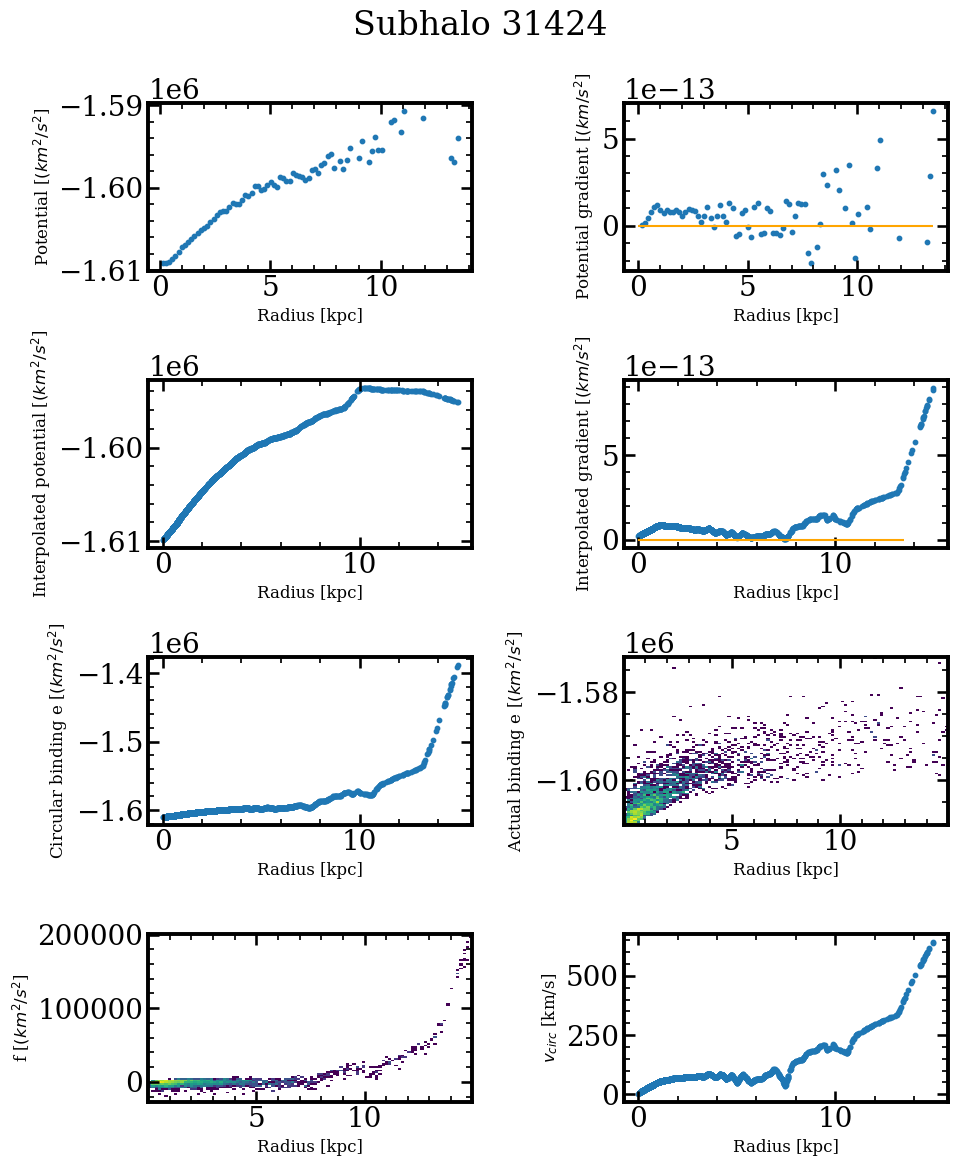

In [23]:
fig,axs = plt.subplots(4,2,figsize=(10,12))

rstars = np.sqrt(Coordinates[:,0]**2 + Coordinates[:,1]**2)
mask = rstars < 15*kpc2km
masked_rstars = rstars[mask]
masked_Potentials = Potentials[mask]
masked_Velocities = Velocities[mask]
interp_g = np.array([gradient_interp(i) for i in masked_rstars])
interp_p = np.array([potental_interp(i) for i in masked_rstars])
vcirc = np.sqrt(masked_rstars * interp_g)

f1 = np.array([interp_p + 0.5*masked_rstars*interp_g])
f2 = masked_Potentials + 0.5*np.linalg.norm(masked_Velocities,axis=1)**2
f = f1 - f2

axs[0,0].scatter(pos,potential_binned,s = 10)
axs[0,0].set_xlabel("Radius [kpc]",size=12)
axs[0,0].set_ylabel("Potential [$(km^2/s^{2}$]",size=12)

axs[0,1].scatter(pos,grad,s = 10)
axs[0,1].hlines(0,0,np.max(pos),color='orange')
axs[0,1].set_xlabel("Radius [kpc]",size=12)
axs[0,1].set_ylabel("Potential gradient [$(km/s^{2}$]",size=12)

axs[1,0].scatter(masked_rstars/kpc2km,interp_p,s = 10)
axs[1,0].set_xlabel("Radius [kpc]",size=12)
axs[1,0].set_ylabel("Interpolated potential [$(km^2/s^{2}$]",size=12)

axs[1,1].scatter(masked_rstars/kpc2km,interp_g,s = 10)
axs[1,1].hlines(0,0,np.max(pos),color='orange')
axs[1,1].set_xlabel("Radius [kpc]",size=12)
axs[1,1].set_ylabel("Interpolated gradient [$(km/s^{2}$]",size=12)

axs[2,0].scatter(masked_rstars/kpc2km,f1,s = 10)
axs[2,0].set_xlabel("Radius [kpc]",size=12)
axs[2,0].set_ylabel("Circular binding e [$(km^2/s^{2}$]",size=12)
# axs[2,0].set_ylim(-1.8e6,-1.4e6)

counts1, xedges1, yedges1, im1 = axs[2,1].hist2d(masked_rstars/kpc2km,f2,norm='log',bins=100)
axs[2,1].set_xlabel("Radius [kpc]",size=12)
axs[2,1].set_ylabel("Actual binding e [$(km^2/s^{2}$]",size=12)
# axs[2,1].set_ylim(-1.8e6,-1.4e6)

counts1, xedges1, yedges1, im1 = axs[3,0].hist2d(masked_rstars/kpc2km,f[0],norm='log',bins=100)
axs[3,0].set_xlabel("Radius [kpc]",size=12)
axs[3,0].set_ylabel("f [$(km^2/s^{2}$]",size=12)

axs[3,1].scatter(masked_rstars/kpc2km,vcirc,s = 10)
axs[3,1].set_xlabel("Radius [kpc]",size=12)
axs[3,1].set_ylabel("$v_{circ}$ [km/s]",size=12)

fig.suptitle("Subhalo {}".format(subhalo_id))
plt.tight_layout()
plt.savefig('Plots/Subhalo_{}_diagnostics_smoothed'.format(subhalo_id))

/tmp/ipykernel_661090/1133102651.py:2: RuntimeWarning: invalid value encountered in sqrt
  smoothed_vcirc = np.sqrt(rstars * smoothed_interp_g)


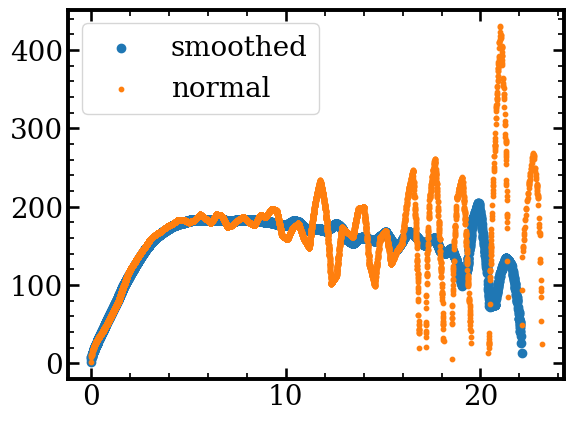

In [171]:
smoothed_interp_g = np.array([smooth_gradient_interp(i) for i in rstars])
smoothed_vcirc = np.sqrt(rstars * smoothed_interp_g)

plt.scatter(rstars/kpc2km,smoothed_vcirc,label='smoothed')
plt.scatter(masked_rstars/kpc2km,vcirc,s = 10,label='normal')
plt.legend()

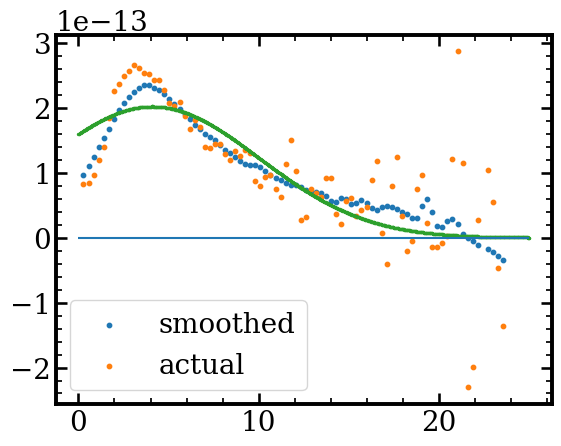

In [148]:
smoothed_g = savgol_filter(grad, window_length=15, polyorder=1)

smooth_gradient_interp = interp1d(pos*kpc2km, smoothed_g, kind='linear', fill_value="extrapolate")

x = pos*kpc2km
params, covariance = curve_fit(gaussian,x,grad,p0 = [2.2e-13,3*kpc2km,5*kpc2km])
xfit = np.linspace(0,25,1000)*kpc2km
yfit = gaussian(xfit,params[0],params[1],params[2])

# plt.scatter(rstars/kpc2km,0.5*(rstars)*np.array([smooth_gradient_interp(i) for i in rstars]),s=5,alpha=0.5,label='interpolated')
# plt.scatter(pos,0.5*(pos*kpc2km)*np.array([smooth_gradient_interp(i*kpc2km) for i in pos]))
plt.scatter(pos,smoothed_g,s = 10,label='smoothed')
plt.scatter(pos,grad,s = 10,label='actual')
plt.scatter(xfit/kpc2km,yfit,s=2)
plt.hlines(0,0,25)
# plt.xlim(0,50)
# plt.ylim(-100,20000)
plt.legend()

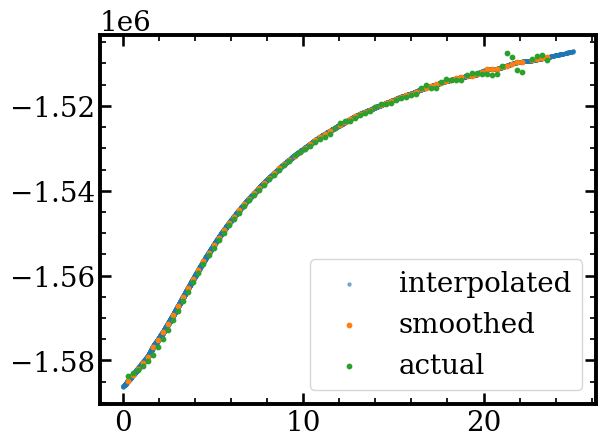

In [96]:
smoothed_p = savgol_filter(potential_binned, window_length=10, polyorder=1)
smoothed_potental_interp = interp1d(pos*kpc2km, smoothed_p, kind='linear', fill_value="extrapolate")

plt.scatter(rstars/kpc2km,np.array([smoothed_potental_interp(i) for i in rstars]),s=5,alpha=0.5,label='interpolated')
plt.scatter(pos,smoothed_p,s = 10,label='smoothed')
plt.scatter(pos,potential_binned,s = 10,label='actual')
plt.legend()

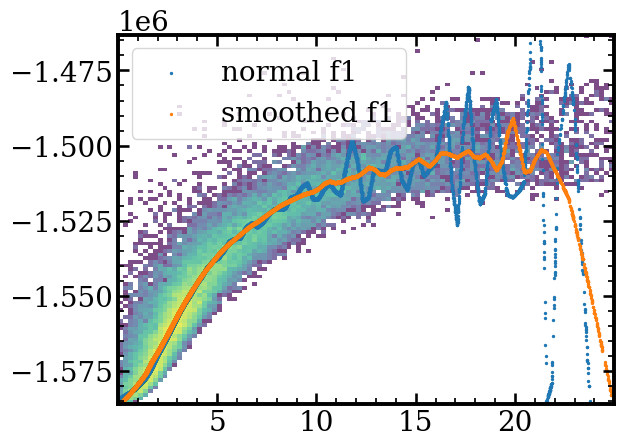

In [140]:
smoothed_f1 = 0.5*(rstars)*np.array([smooth_gradient_interp(i) for i in rstars]) + np.array([smoothed_potental_interp(i) for i in rstars])

counts1, xedges1, yedges1, im1 = plt.hist2d(rstars/kpc2km,f2,norm='log',bins=100,alpha=0.7)
plt.scatter(rstars/kpc2km,f1,label='normal f1',s=2)
plt.scatter(rstars/kpc2km,smoothed_f1,label='smoothed f1',s=2)
plt.legend()

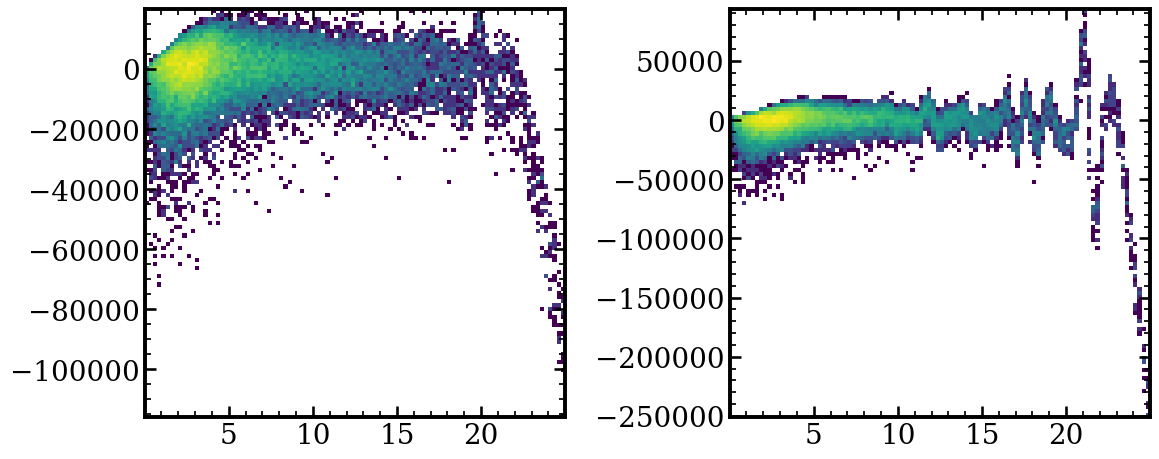

In [141]:
smoothedf = smoothed_f1 - f2

fig,axs = plt.subplots(1,2,figsize = (12,5))

counts1, xedges1, yedges1, im1 = axs[0].hist2d(rstars/kpc2km,smoothedf,norm='log',bins=100)
counts1, xedges1, yedges1, im1 = axs[1].hist2d(rstars/kpc2km,f[0],norm='log',bins=100)
plt.tight_layout()

Text(0.5, 1.0, 'Subhalo 52')

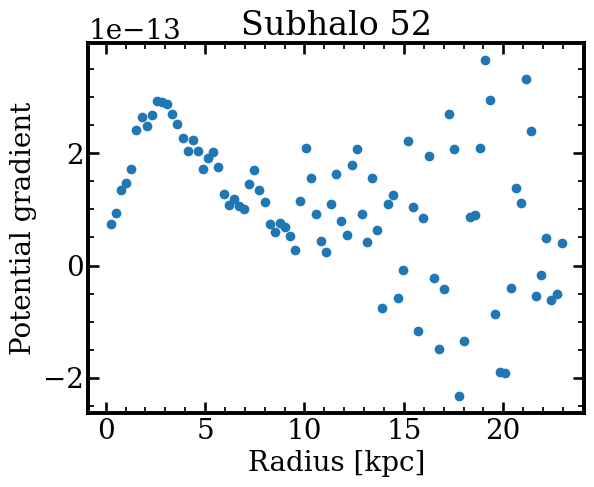

In [16]:
plt.scatter(pos,grad)
plt.xlabel("Radius [kpc]")
plt.ylabel("Potential gradient")
plt.title('Subhalo {}'.format(subhalo_id))
# plt.savefig('Plots/Subhalo_{}_gradphi_r'.format(subhalo_id))

In [12]:
mask = (ratio2 < 25) & (ratio2 > -25) & (~np.isnan(ratio2))
ratio2 = ratio2[mask]
Velocities = Velocities[mask]

In [13]:
disks = [(ratio2[i] > 0.5) & (ratio2[i] < 1) for i in range(len(ratio2))]
bulges = [ratio2[i] < 0.5 for i in range(len(ratio2))]
disk_vel = Velocities[disks]
bulge_vel = Velocities[bulges]

In [83]:
disk_vel_3d = np.sqrt(disk_vel[:,0]**2 + disk_vel[:,1]**2 + disk_vel[:,2]**2 )
bulge_vel_3d = np.sqrt(bulge_vel[:,0]**2 + bulge_vel[:,1]**2 + bulge_vel[:,2]**2 )

print("Disk sigma:",np.std(disk_vel_3d),"Bulge sigma:",np.std(bulge_vel_3d))

Disk sigma: 25.911217 Bulge sigma: 37.16182


In [25]:
Vel3d = np.linalg.norm(Velocities,axis=1)

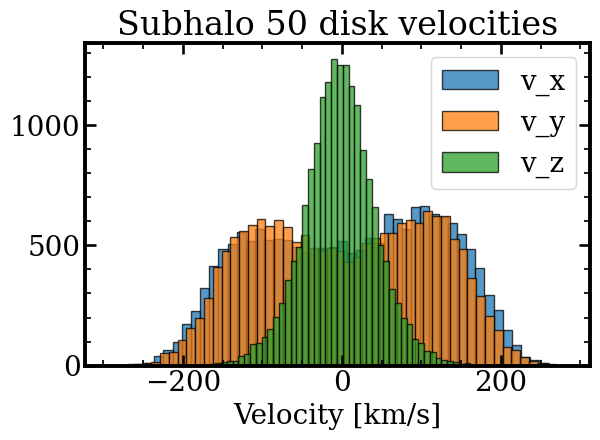

In [15]:
plt.hist(disk_vel[:,0],bins=50,edgecolor='black',label = 'v_x',alpha=0.75)
plt.hist(disk_vel[:,1],bins=50,edgecolor='black',label = 'v_y',alpha=0.75)
plt.hist(disk_vel[:,2],bins=50,edgecolor='black',label = 'v_z',alpha=0.75)

# plt.text(-550,7000,f"$\sigma:${np.std(disk_vel_3d):.2f} km/s")
plt.legend()
plt.title("Subhalo {} disk velocities".format(subhalo_id))
plt.xlabel("Velocity [km/s]")
plt.tight_layout()
plt.savefig('Plots/Subhalo_{}_vel_disk.png'.format(subhalo_id))

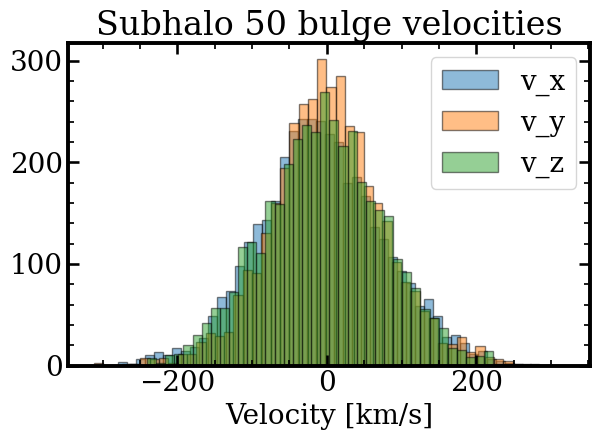

In [16]:
plt.hist(bulge_vel[:,0],bins=50,edgecolor='black',label = 'v_x',alpha=0.5)
plt.hist(bulge_vel[:,1],bins=50,edgecolor='black',label = 'v_y',alpha=0.5)
plt.hist(bulge_vel[:,2],bins=50,edgecolor='black',label = 'v_z',alpha=0.5)

# plt.text(-650,4000,f"$\sigma:${np.std(bulge_vel_3d):.2f} km/s")
plt.legend()
plt.title("Subhalo {} bulge velocities".format(subhalo_id))
plt.xlabel("Velocity [km/s]")
plt.tight_layout()
plt.savefig('Plots/Subhalo_{}_vel_bulge.png'.format(subhalo_id))

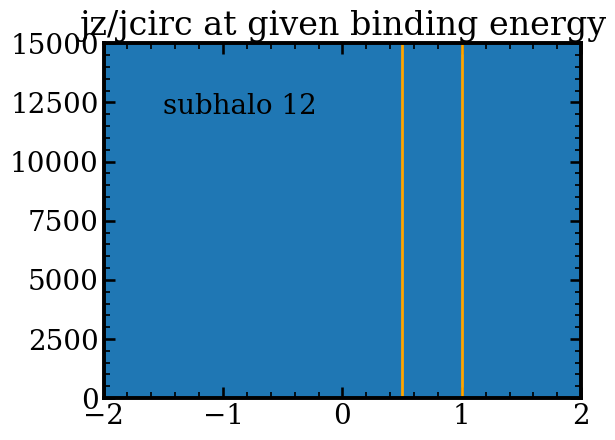

In [5]:
plt.hist(ratio2,bins=500,edgecolor='black')
plt.vlines([0.5,1],0,20000,color = 'orange',lw=2)
plt.ylim(0,15000)
plt.xlim(-2,2)
plt.title("jz/jcirc at given binding energy")
plt.text(-1.5,12000,'subhalo {}'.format(subhalo_id))
plt.tight_layout()
plt.savefig('Plots/Subhalo_{}_jz_jcirc_e.png'.format(subhalo_id))

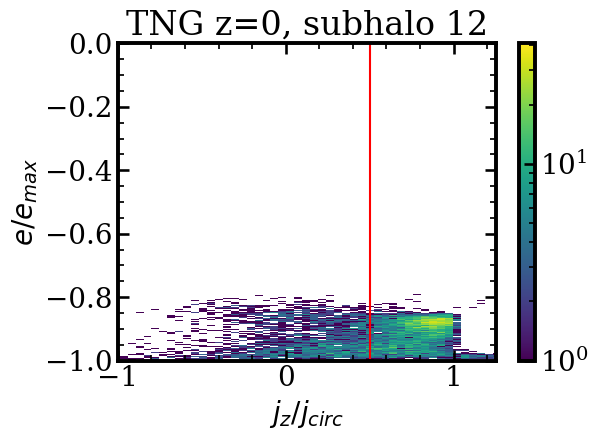

In [27]:
fig,ax=plt.subplots()

no_nans=~np.isnan(ratio2)
counts1, xedges1, yedges1, im1 = ax.hist2d(ratio2,e_bind_norm[mask],norm='log',bins=(1000,1000))

fig.colorbar(im1, ax=ax)
# ax.hlines([0.7,1.3],0,100,color='orange',lw=2,ls = '--')
# ax.hlines(1,0,100,color='orange',lw=2)
ax.vlines(0.5,-1,0,color='red')
plt.xlim(-1,1.25)
plt.ylim(-1,0)
plt.xlabel('$j_z/j_{circ}$')
plt.ylabel('$e/e_{max}$')
plt.title('TNG z=0, subhalo {}'.format(subhalo_id))
plt.tight_layout()
plt.savefig('Plots/TNG_subhalo_{}_emax_jz.png'.format(subhalo_id))

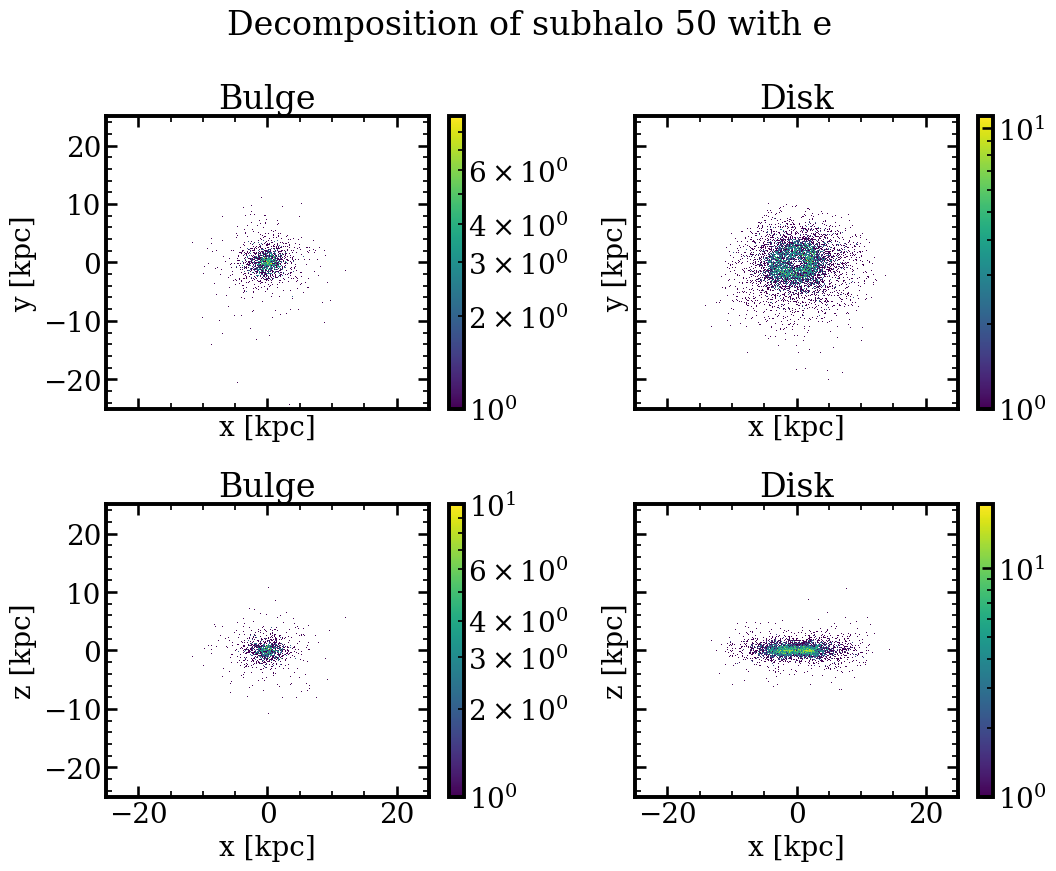

In [17]:
disks = [(ratio2[i] > 0.5) & (ratio2[i] < 1.3) for i in range(len(ratio2))]
bulges = [ratio2[i] < 0.5 for i in range(len(ratio2))]
Coord = Coordinates[mask]/kpc2km
Bulge = Coord[bulges]
Disk = Coord[disks]

fig,axs=plt.subplots(2,2,figsize = (11,9),sharex=True,sharey=True)

counts1, xedges1, yedges1, im1 = axs[0,0].hist2d(Bulge[:,0],Bulge[:,1],norm='log',bins=300)
counts2, xedges2, yedges2, im2 = axs[0,1].hist2d(Disk[:,0],Disk[:,1],norm='log',bins=300)
axs[0,0].set_title('Bulge')
axs[0,1].set_title('Disk')
axs[0,0].set_xlabel('x [kpc]')
axs[0,1].set_xlabel('x [kpc]')
axs[0,0].set_ylabel('y [kpc]')
axs[0,1].set_ylabel('y [kpc]')

counts3, xedges3, yedges3, im3 = axs[1,0].hist2d(Bulge[:,0],Bulge[:,2],norm='log',bins=300)
counts4, xedges4, yedges4, im4 = axs[1,1].hist2d(Disk[:,0],Disk[:,2],norm='log',bins=300)

axs[1,0].set_title('Bulge')
axs[1,1].set_title('Disk')
axs[1,0].set_xlabel('x [kpc]')
axs[1,1].set_xlabel('x [kpc]')
axs[1,0].set_ylabel('z [kpc]')
axs[1,1].set_ylabel('z [kpc]')

for ax in axs.flatten():
    ax.set_xlim(-25,25)
    ax.set_ylim(-25,25)

fig.colorbar(im1, ax=axs[0,0])
fig.colorbar(im2, ax=axs[0,1])
fig.colorbar(im3, ax=axs[1,0])
fig.colorbar(im4, ax=axs[1,1])

fig.suptitle('Decomposition of subhalo {} with e'.format(subhalo_id))

fig.tight_layout()
fig.savefig('Plots/Subhalo_{}_decomp_0.5_e.png'.format(subhalo_id))

# Now testing binding energy function:

In [2]:
TNGpath='/standard/torrey-group/IllustrisTNG/Runs/L75n1820TNG'
basePath = TNGpath
snap_num=99 # z=0
subhalo_id = 0
hdr  = il.groupcat.loadHeader(TNGpath, snap_num)
h = hdr['HubbleParam'] ## load in h from the header
box_size = hdr["BoxSize"]
redshift = hdr['Redshift']
a = 1/(1+redshift)

In [26]:
Gas_Props

{'count': 0}

In [28]:
Gas_Props = il.snapshot.loadSubhalo(basePath, snap_num, subhalo_id, 0, fields=fields)
Gas_Props

{'count': 0}

In [ ]:
fields = ['Coordinates','Masses']
basePath = '/standard/torrey-group/IllustrisTNG/Runs/L75n1820TNG'
snap_num = 99
subhalo_id = 10

Subhalovel = il.groupcat.loadSubhalos(basePath,snap_num,fields=['SubhaloVel'])[subhalo_id]

BH_Props = il.snapshot.loadSubhalo(basePath, snap_num, subhalo_id, 5, fields=fields)
Gas_Props = il.snapshot.loadSubhalo(basePath, snap_num, subhalo_id, 0, fields=fields)
fields = ['Coordinates']
DM_Props = il.snapshot.loadSubhalo(basePath, snap_num, subhalo_id, 1, fields=fields)
fields = ['Coordinates','Masses','Velocities','Potential']
Star_Props = il.snapshot.loadSubhalo(basePath, snap_num, subhalo_id, 4, fields=fields)

keys = ["Gas", "DM", "Stars", "BHs"]
Masses = {"Gas":Gas_Props['Masses'],"DM":7.5e6*np.ones(len(DM_Props)),"Stars":Star_Props['Masses'],"BHs":BH_Props['Masses']}
Coordinates = {"Gas":Gas_Props['Coordinates'],"DM":DM_Props,"Stars":Star_Props['Coordinates'],
               "BHs":BH_Props['Coordinates']}
Velocities = Star_Props['Velocities'] - Subhalovel

# Correcting units 
Msun2g = 1.989e33
kpc2km = 3.0857e16
Masses = {keys[i]:(Msun2g*1e10/h)*Masses[keys[i]] for i in range(len(keys))} # Units: g
Coordinates = {keys[i]:(kpc2km*a/h)*Coordinates[keys[i]] for i in range(len(keys))} # Units: km
Velocities *= np.sqrt(a) # Units: km/s

binding_energies = compute_binding_energy(Masses,Coordinates,Velocities)

In [ ]:
binding_energies

In [ ]:
old_binding = 0.5 * np.linalg.norm(Velocities,axis=1)**2 + Star_Props['Potential']

In [ ]:
old_binding

# Testing loading in data:

In [97]:
Ratios,Sigmas,BH_Masses,Coords,Star_Masses,Pot_radii,Pot_grads,e_bind_norms,Central_ids,Subhalo_vels = ReadBrahmaData('Brahma_Data/Kin_Decomp_TNG_z0_r0.5_e2')

In [100]:
ratio0 = Ratios[0]

mask0 = (ratio0 < 25) & (ratio0 > -25) & (~np.isnan(ratio0))
ratio0_masked = ratio0[mask0]

In [119]:
Sigmas = np.array([np.linalg.norm(sigma) for sigma in Sigmas])

In [125]:
BH_Masses

array([0.019117778, 0.0101484, 0.0013636095, 0.0055598803, 0.010758704,
       0.01989609, 0.011647446, 0.011170232, 0.003446506, 0.011943526,
       0.0057016546, 0.003130177, 0.006598359, 0.011405954, 0.0028970442,
       0.012535342, 0.007401289, 0.01498043, 0.0001600668, 0.010270544,
       0.04369593, 0.003792273, 0.003132757, {'count': 0}, 0.0026558924,
       0.0028668123, 0.017134314, 0.015888581, 0.011222296, 0.0028002046,
       0.009783395, 0.004234949, 0.0046578133, 0.0032531174, 0.0070394976,
       0.0051028784, 0.0042159157, 0.003979957, 0.003130034, 0.0058620796,
       {'count': 0}, {'count': 0}, 0.006895716, 0.0033569846,
       0.0008889014, 0.004514904, {'count': 0}, 0.0004974906,
       0.0011660819, {'count': 0}, {'count': 0}, 0.007007093,
       8.0000005e-05, {'count': 0}, 0.0026050874, 0.0029107435,
       {'count': 0}, 0.0028151572, 0.0041104294, 0.003963721],
      dtype=object)

In [126]:
BH_Masses = np.array(BH_Masses)
BH_Masses[BH_Masses =={'count': 0}] = np.nan

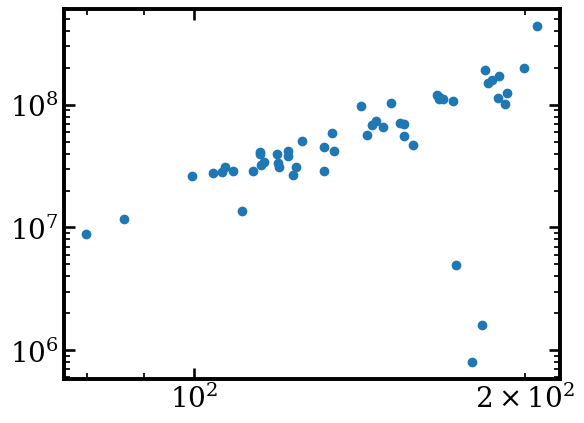

In [133]:
plt.scatter(Sigmas,BH_Masses*1e10)
plt.xscale('log')
plt.yscale('log')

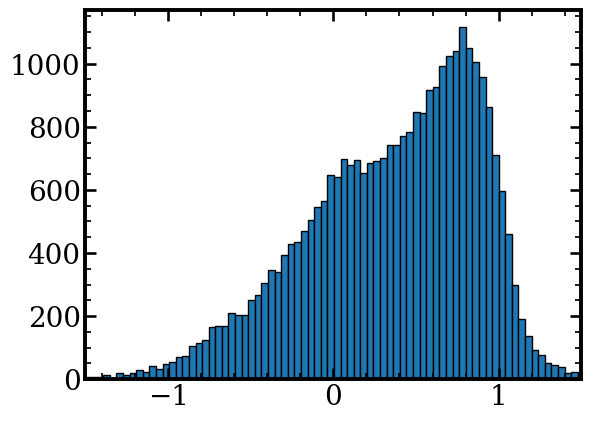

In [106]:
plt.hist(ratio0_masked,bins=1000,edgecolor='black')
plt.xlim(-1.5,1.5)
plt.show()

# Testing Brahma_Decomp script:

In [1]:
'''
Now recalculating M-sigma for Brahma sims with the bulge-disk decomposition
'''

from brahma_analysis import *
import sys
import os
sys.path.append('/home/yja6qa/arepo_package')

import numpy as np
import arepo_package
import math
import matplotlib.pyplot as plt
import illustris_python as il
import pickle

sys.stdout = sys.__stdout__
sys.stderr = sys.__stderr__

# Setting path and constants for this job
path_to_output='/standard/torrey-group/BRAHMA/L12p5n512' # this is the folder containing the simulation run
run='/AREPO/' # name of the simulation runs
output='output_ratio10_SFMFGM5_seed5.00_' # Base name included in every box

# Change these!
box = 'bFOF' # Name of the box we want to load data from
desired_redshift=5 # Redshift of box that I want
nstars_min = 30

basePath = path_to_output+run+output+box # Combining paths to read data in 
file_format='fof_subfind'
kpc2km=3.0857e16 # Conversion from kpc to km for units

print('Making Subhalo masks...', flush=True)
SubhaloLenType,o = arepo_package.get_subhalo_property(basePath,'SubhaloLenType',desired_redshift,postprocessed=1)
SubhaloBHLen = SubhaloLenType[:,5]
SubhaloStarsLen = SubhaloLenType[:,4]
SubhaloIndices = np.arange(0,len(SubhaloBHLen))
mask = np.logical_and(SubhaloBHLen>0,SubhaloStarsLen>nstars_min)  # Only subhalos with a BH and with 1000 stars

SubhaloIndicesWithBH = SubhaloIndices[mask] # Return these so we can cross-reference which subhalos to plot

print('Loading header info...', flush=True)
output_redshift,output_snapshot=arepo_package.desired_redshift_to_output_redshift(basePath,
                                                                    desired_redshift,list_all=False,file_format=file_format)
hdr  = il.groupcat.loadHeader(basePath, output_snapshot)
h = hdr['HubbleParam'] ## load in h from the header
box_size = hdr['BoxSize']
redshift = hdr['Redshift']

print('Loading star and BH properties', flush=True)

Stellar_vel=il.snapshot.loadSubset_groupordered(basePath,output_snapshot,partType=4,fields='Velocities')
Stellar_pos=il.snapshot.loadSubset_groupordered(basePath,output_snapshot,partType=4,fields='Coordinates')
Stellar_pot=il.snapshot.loadSubset_groupordered(basePath,output_snapshot,partType=4,fields='Potential')
Stellar_mass=il.snapshot.loadSubset_groupordered(basePath,output_snapshot,partType=4,fields='Masses')
requested_property=il.snapshot.loadSubset_groupordered(basePath,output_snapshot,partType=5,fields='BH_Mass')

# Grabbing stellar age; negative ages are wind particles that should not be included in sigma calculation
Age=il.snapshot.loadSubset_groupordered(basePath,output_snapshot,partType=4,fields='GFM_StellarFormationTime')

# Subhalo properties
Subhaloprops,o =  arepo_package.get_subhalo_property(basePath,['SubhaloVel','SubhaloPos','SubhaloHalfmassRad'],desired_redshift,postprocessed=1)

# Scale factor calculation for unit corrections
a = 1/(1+output_redshift)

# Initialize lists to append to:
Ratios = []
Bulge_sigmas = []
Disk_sigmas = []
Total_sigmas = []
BH_Masses = []
Star_Masses = []
Coords = []
Subhalo_vels = []
failed_subhalos = 0


for index in SubhaloIndicesWithBH:
    Vel_subhalo,Vel_group,output_redshift=get_particle_property_within_postprocessed_groups_adj(basePath,'Velocities',4,output_redshift,index,Stellar_vel,store_all_offsets=1,group_type='subhalo')
    pos_subhalo,pos_group,output_redshift=get_particle_property_within_postprocessed_groups_adj(basePath,'Coordinates',4,output_redshift,index,Stellar_pos,store_all_offsets=1,group_type='subhalo')
    pot_subhalo,pot_group,output_redshift=get_particle_property_within_postprocessed_groups_adj(basePath,'Potential',4,output_redshift,index,Stellar_pot,store_all_offsets=1,group_type='subhalo')
    mstar_subhalo,mstar_group,output_redshift=get_particle_property_within_postprocessed_groups_adj(basePath,'Masses',4,output_redshift,index,Stellar_mass,store_all_offsets=1,group_type='subhalo')
    Age_subhalo,Age_group,output_redshift=get_particle_property_within_postprocessed_groups_adj(basePath,'GFM_StellarFormationTime',4,output_redshift,index,Age,store_all_offsets=1,group_type='subhalo')
    BHMasses_subhalo,BHMasses_group,output_redshift=get_particle_property_within_postprocessed_groups_adj(basePath,'BH_Mass',5,desired_redshift,index,requested_property,store_all_offsets=1,group_type='subhalo')
    
    # Removing wind particles
    mask = Age_subhalo > 0
    Vel_subhalo = Vel_subhalo[mask]
    mstar_subhalo = mstar_subhalo[mask]
    pot_subhalo = pot_subhalo[mask]
    pos_subhalo = pos_subhalo[mask]

    Star_Props = {'Masses':mstar_subhalo,'Coordinates':pos_subhalo,'Velocities':Vel_subhalo,'Potential':pot_subhalo}
    HMR = Subhaloprops['SubhaloHalfmassRad'][index]
    
    Coordinates,Velocities,Potentials = Center_subhalo(Star_Props,Subhaloprops,box_size,redshift,h,subhalo_id=index)

    # If there are at least 1000 stars, proceed normally
    if len(Coordinates) > 1000:
        Vals = kinematic_decomp_e2(Coordinates,Velocities,Potentials,HMR,nstars_min=nstars_min)
    # Otherwise, set the number of stars per bin to be ~1/20 the total number of stars, to make ~20 bins
    else:
        Vals = kinematic_decomp_e2(Coordinates,Velocities,Potentials,HMR,nstars_min=nstars_min,nstars=int(len(Coordinates)/20))

    if Vals == np.nan: # Some subhalos still have less stars than nstars_min apparently...
        continue
    else:
        ratio,negids,rcs = Vals[0],Vals[1],Vals[2]
        
    Velocities[negids] = np.nan

    # Take the 3D velocity before doing standard deviation calculation
    Vel3d = np.linalg.norm(Velocities,axis=1)
    
    bulge = ratio < 0.5
    disk = (ratio > 0.5) & (ratio < 1)

    Bulge_vel = Vel3d[bulge]
    Bulge_mass = mstar_subhalo[bulge]

    Disk_vel = Vel3d[disk]
    Disk_mass = mstar_subhalo[disk]
    
    # Calculate the velocity dispersion

    Mbulge_total = np.sum(Bulge_mass) # Total stellar mass
    Mdisk_total = np.sum(Disk_mass)
    Mstars_total = np.sum(mstar_subhalo)

    # Here we weight the sigma calculation by stellar mass
    mu_vel_bulge = np.mean(Bulge_vel,axis=0) # Average 3D stellar velocity for this subhalo
    mu_vel_disk = np.mean(Disk_vel,axis=0) 
    mu_vel_total = np.mean(Vel3d,axis=0) 
    
    BulgeDiffSquared=Bulge_mass*np.array((Bulge_vel - mu_vel_bulge)** 2)
    DiskDiffSquared=Disk_mass*np.array((Disk_vel - mu_vel_disk)** 2)
    TotalDiffSquared=mstar_subhalo*np.array((Vel3d - mu_vel_total)** 2)
    
    Sigma_bulge = np.sqrt(np.sum(BulgeDiffSquared) / Mbulge_total)  # Calculate sigma from subhalo velocity
    Sigma_disk = np.sqrt(np.sum(DiskDiffSquared) / Mdisk_total)
    Sigma_total = np.sqrt(np.sum(TotalDiffSquared) / Mstars_total)

    if len(ratio[~np.isnan(ratio)]) == 0:
        failed_subhalos += 1
        print("Subhalo {} failed".format(index), flush=True)
    else:
        print('Subhalo: {},'.format(index),'Bulge sigma: {},'.format(Sigma_bulge),'Total sigma: {},'.format(Sigma_total),
              'BH mass: {},'.format(np.max(np.max(BHMasses_subhalo)*1e10*h)),
              'Ratio max/min: {},'.format((np.max(ratio[~np.isnan(ratio)]),np.min(ratio[~np.isnan(ratio)])) ) , flush=True)

    Ratios.append(ratio)
    Bulge_sigmas.append(Sigma_bulge)
    Disk_sigmas.append(Sigma_disk)
    Total_sigmas.append(Sigma_total)
    BH_Masses.append(np.max(BHMasses_subhalo)*1e10*h)
    Star_Masses.append(np.sum(mstar_subhalo)*1e10*h)
    Coords.append(Coordinates)
    Subhalo_vels.append(Velocities)

Write2File(Ratios,Bulge_sigmas,Disk_sigmas,Total_sigmas,BH_Masses,Star_Masses,Coords,Subhalo_vels,
           fname=f'Brahma_Data/{box}_z{desired_redshift}_decomp')

Making Subhalo masks...
Loading header info...
Loading star and BH properties
Number of stars per bin: 150
Nonzero rcs: 6084 Skipped stars: 1
Subhalo: 0, Bulge sigma: 66.72220611572266, Total sigma: 62.797447204589844, BH mass: 24877308.489521965, Ratio max/min: (3.5828094662798935, -2.3522348041544774),
Number of stars per bin: 150
Nonzero rcs: 2074 Skipped stars: 0
Subhalo: 1, Bulge sigma: 67.39945220947266, Total sigma: 65.32518005371094, BH mass: 13753741.436172277, Ratio max/min: (1.576805516343407, -1.2868992221006976),
Number of stars per bin: 5
Nonzero rcs: 97 Skipped stars: 19
Subhalo: 2, Bulge sigma: 24.546358108520508, Total sigma: 30.630144119262695, BH mass: 1300586.3814905751, Ratio max/min: (1.4360589570754605, -0.9179503862080939),
Number of stars per bin: 6
Nonzero rcs: 98 Skipped stars: 33
Subhalo: 3, Bulge sigma: 21.228986740112305, Total sigma: 32.0129508972168, BH mass: 4217959.566798527, Ratio max/min: (0.7784085026021016, -0.5271079378186136),
Number of stars per

/home/yja6qa/.conda/envs/kho_env/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yja6qa/.conda/envs/kho_env/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_195730/2485627501.py:141: RuntimeWarning: invalid value encountered in scalar divide
  Sigma_bulge = np.sqrt(np.sum(BulgeDiffSquared) / Mbulge_total)  # Calculate sigma from subhalo velocity
/tmp/ipykernel_195730/2485627501.py:142: RuntimeWarning: invalid value encountered in scalar divide
  Sigma_disk = np.sqrt(np.sum(DiskDiffSquared) / Mdisk_total)


Number of stars per bin: 46
Nonzero rcs: 938 Skipped stars: 0
Subhalo: 278, Bulge sigma: 57.49917984008789, Total sigma: 55.29063034057617, BH mass: 6195201.999682467, Ratio max/min: (567.2144207404444, -2.287526458868598),
Number of stars per bin: 18
Nonzero rcs: 362 Skipped stars: 5
Subhalo: 279, Bulge sigma: 33.07917022705078, Total sigma: 33.186309814453125, BH mass: 3737826.1926351115, Ratio max/min: (1.6421488244453863, -2.1790645973091776),
Number of stars per bin: 14
Nonzero rcs: 281 Skipped stars: 0
Subhalo: 280, Bulge sigma: 45.915245056152344, Total sigma: 42.95066833496094, BH mass: 3347800.6168152206, Ratio max/min: (1.5089726276435842, -1.2107562885538254),
Number of stars per bin: 13
Nonzero rcs: 265 Skipped stars: 1
Subhalo: 281, Bulge sigma: 33.14556884765625, Total sigma: 31.789709091186523, BH mass: 3694187.5930060633, Ratio max/min: (1.331571765465826, -1.0791668093534577),


/sfs/gpfs/tardis/home/yja6qa/arepo_package/brahma_analysis.py:1263: OptimizeWarning: Covariance of the parameters could not be estimated
  params, covariance = curve_fit(model, (x, y), Potentials_masked)


Number of stars per bin: 3
Nonzero rcs: 1 Skipped stars: 59
Subhalo 283 failed
Number of stars per bin: 150
Nonzero rcs: 2222 Skipped stars: 0
Subhalo: 340, Bulge sigma: 69.12811279296875, Total sigma: 65.75761413574219, BH mass: 15608262.303750962, Ratio max/min: (1.5911004787409244, -1.4713409270296125),
Number of stars per bin: 150
Nonzero rcs: 3173 Skipped stars: 0
Subhalo: 379, Bulge sigma: 60.570743560791016, Total sigma: 56.874515533447266, BH mass: 13402857.5043194, Ratio max/min: (1.8840412687013646, -1.810412981175275),
Number of stars per bin: 29
Nonzero rcs: 467 Skipped stars: 125
Subhalo: 411, Bulge sigma: 31.509490966796875, Total sigma: 37.45912551879883, BH mass: 2280825.9583543986, Ratio max/min: (14.867186856173166, -1.1452691201119918),
Number of stars per bin: 10
Nonzero rcs: 200 Skipped stars: 0
Subhalo: 412, Bulge sigma: 35.07438278198242, Total sigma: 34.9757194519043, BH mass: 2791735.1018695626, Ratio max/min: (1.3244422166316416, -1.1862765613805246),
Number o

KeyboardInterrupt: 